# Reddit's Invisible Brain: The Web Hidden Beneath the Threads
### Mapping the Emotional and Cognitive Architecture of Online Communities

**Project:** ADA 2025 - P3 Final Milestone  
**Team:** Amer Lakrami, Hamza Barrada, Omar El Khyari, Omar Zakariya, Cesar Illanes

---

## About This Notebook

This notebook contains our complete technical analysis of Reddit's hyperlink network (858,488 links across 67,180 subreddits, 2014-2017). 

We integrate three distinct data layers:

1. **Semantic Layer:** What do communities talk about? (K-Means clustering - 40 topics)
2. **Linguistic Layer:** How do they talk? (LIWC features - 65 psychological dimensions)
3. **Network Layer:** Who do they talk to? (PageRank, betweenness, communities)

**Interactive Data Story:** [View here](https://epfl-ada.github.io/ada-2025-project-barrada)

---

## Analysis Pipeline

### Phase 1: Data Processing & Integration (7 steps)
1. **Data Processing** - Extract 858k hyperlinks and parse 86 LIWC/text features
2. **LIWC Analysis** - Aggregate psychological profiles by subreddit (source & target)
3. **Network Analysis** - Compute PageRank, betweenness, Louvain communities
4. **Embedding Processing** - Load 300D vectors, reduce to 50D via PCA
5. **Topic Clustering** - K-Means (K=40) with manual validation
6. **Integration** - Merge all layers into final_dataset.csv (67,180 rows × 161 features)
7. **Cluster Aggregation** - Roll up to cluster_master_dataset.csv (40 clusters)

### Phase 2: Analysis & Visualization
- **Statistical Analysis** - research questions across 5 themes (Roles, Echo Chambers, Network, Conflict, Power)
- **Visualization Pipeline** - Generate 17 static charts and 11 interactive web datasets

### Outputs Generated
- 17 processed datasets (data/processed/)
- 17 static visualizations (results/figures/)
- 20 statistical results (data/processed/rq_analysis/)
- 11 web visualization files (docs/assets/data/)

---

## Imports and Path Setup:

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

try:
    from src.data_processing import HyperlinkDataProcessor
    from src.embedding_processing import process_embeddings
    from src.liwc_analysis import LIWCAnalyzer
    from src.network_analysis import NetworkAnalyzer
    from src.integration import DataIntegrator
    from src.cluster_aggregation import create_cluster_master_dataset
    from src.visualize_pipeline import (
            load_hyperlinks_data,
            plot_sentiment_distribution,
            plot_sentiment_volume_over_time,
            plot_top_sources_sentiment,
            plot_top_targets_sentiment,
            plot_liwc_diverging_lollipop,
            plot_attack_pattern_small_multiples,
            load_pca_variance_data,
            load_embeddings_data,
            plot_pca_variance,
            load_liwc_sentiment_comparison,
            load_subreddit_roles,
            load_psychological_profiles,
            plot_role_quadrant_map,
            plot_psychological_asymmetry,
            load_network_metrics,
            load_network_communities,
            plot_centrality_grid,
            load_topic_clusters,
            plot_topic_cluster_distribution,
            load_final_dataset,
            load_cluster_labels,
            plot_topic_network_role,
            plot_semantic_structural_heatmap,
            plot_top_influential,
            plot_top_supported,
            plot_liwc_role_lift,
            plot_liwc_radar_profiles
    )
    from src.topic_clustering import run_topic_clustering
    from src.research_questions import ResearchQuestions
    from scripts.prepare_data import VisualizationDataPrep
    print("Successfully imported all pipeline classes from 'src' directory.")
except ImportError as e:
    print(f"Details: {e}")

BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = BASE_DIR / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'

BODY_LINKS_PATH = DATA_DIR / 'hyperlink_network' / 'soc-redditHyperlinks-body.tsv'
TITLE_LINKS_PATH = DATA_DIR / 'hyperlink_network' / 'soc-redditHyperlinks-title.tsv'
EMBEDDINGS_PATH = DATA_DIR / 'subreddit_embeddings' / 'web-redditEmbeddings-subreddits.csv'

PROCESSED_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

Successfully imported all pipeline classes from 'src' directory.


---
## Analysis Pipeline

### Step 1: Data Processing (Hyperlink & LIWC Extraction)

**Goal:** Load and clean the raw hyperlink data, combine the `body` and `title` files, and parse the `PROPERTIES` string.

This first step reads the 858,490 hyperlink entries and parse the `PROPERTIES` vector into 86 distinct features:
* **21 Text Properties** (word count, readability, VADER sentiment, etc.)
* **65 LIWC Features** (psychological linguistics like `LIWC_Anger`, `LIWC_We`, `LIWC_Cognitive`, etc.)

This gives us our base dataset of *individual links* and their associated psychological/textual properties.
**Output:** `combined_hyperlinks.csv` - our base dataset of individual links with psychological/textual properties.

In [19]:
# Process Hyperlinks
print("Initializing HyperlinkDataProcessor...")
processor_hp = HyperlinkDataProcessor(
    body_path=BODY_LINKS_PATH, 
    title_path=TITLE_LINKS_PATH,
    output_dir=PROCESSED_DIR
)

# Run the processing pipeline
hyperlinks_df, liwc_columns = processor_hp.run()

# Results
print("\n--- Step 1 Output ---")
print(f"Total LIWC columns extracted: {len(liwc_columns)}")
print("DataFrame Info:")
hyperlinks_df.info()

print("\nSample of processed hyperlink data (first 5 rows):")
display(hyperlinks_df.head())

Initializing HyperlinkDataProcessor...
Data Preprocessing....
LOADING HYPERLINK DATA

 Loading files...
Body links:   286,561 rows
Title links:  571,927 rows
Combined:  858,488 rows

Extracting features from PROPERTIES...
Extracted 21 text properties
Extracted 65 LIWC features
DATA CLEANING
 Standardized subreddit names (lowercase, trimmed)
Created binary sentiment indicators
Parsed timestamp into datetime, year, month, date

 Final dataset: 858,488 rows × 105 columns
DATA VALIDATION
All required columns present
No nulls in critical columns

Sentiment distribution (LINK_SENTIMENT):
 -1:   82,210 (  9.6%)
  1:  776,278 ( 90.4%)

Network composition:
Unique subreddits:    67,180
As sources:           55,863
As targets:           34,572
Unique links:        858,488

 Time range:
From: 2013-12-31 16:20:20
To:   2017-04-30 16:58:21

 Saved to: /home/hamza/ada-2025-project-barrada/data/processed/combined_hyperlinks.csv
PREPROCESSING COMPLETE

--- Step 1 Output ---
Total LIWC columns extracte

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,LINK_SOURCE,n_characters,n_characters_no_space,frac_alpha,frac_digits,frac_uppercase,frac_whitespace,frac_special,n_words,n_unique_words,n_long_words,avg_word_length,n_unique_stopwords,frac_stopwords,n_sentences,n_long_sentences,avg_chars_per_sentence,avg_words_per_sentence,readability_index,vader_positive,vader_negative,vader_compound,LIWC_Funct,LIWC_Pronoun,LIWC_Ppron,LIWC_I,LIWC_We,LIWC_You,LIWC_SheHe,LIWC_They,LIWC_Ipron,LIWC_Article,LIWC_Verbs,LIWC_AuxVb,LIWC_Past,LIWC_Present,LIWC_Future,LIWC_Adverbs,LIWC_Prep,LIWC_Conj,LIWC_Negate,LIWC_Quant,LIWC_Numbers,LIWC_Swear,LIWC_Social,LIWC_Family,LIWC_Friends,LIWC_Humans,LIWC_Affect,LIWC_Posemo,LIWC_Negemo,LIWC_Anx,LIWC_Anger,LIWC_Sad,LIWC_CogMech,LIWC_Insight,LIWC_Cause,LIWC_Discrep,LIWC_Tentat,LIWC_Certain,LIWC_Inhib,LIWC_Incl,LIWC_Excl,LIWC_Percept,LIWC_See,LIWC_Hear,LIWC_Feel,LIWC_Bio,LIWC_Body,LIWC_Health,LIWC_Sexual,LIWC_Ingest,LIWC_Relativ,LIWC_Motion,LIWC_Space,LIWC_Time,LIWC_Work,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler,sentiment_numeric,is_positive,is_negative,timestamp,year,month,date,LIWC_Emotion_Total,LIWC_Negemo_Specific,LIWC_Cognitive_Total,LIWC_Social_Total,LIWC_Pronoun_Total
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",body,345.0,298.0,0.756522,0.017391,0.086957,0.150725,0.075362,57.0,53.0,10.0,4.789474,15.0,0.315789,1.0,1.0,345.000000,57.000000,35.577895,0.073,0.080,0.1748,0.344828,0.051724,0.034483,0.000000,0.034483,0.000000,0.000000,0.0,0.017241,0.051724,0.103448,0.051724,0.000000,0.103448,0.000000,0.034483,0.034483,0.068966,0.017241,0.034483,0.000000,0.0,0.103448,0.000000,0.0,0.000000,0.051724,0.017241,0.034483,0.000000,0.000000,0.017241,0.189655,0.034483,0.0,0.034483,0.034483,0.000000,0.000000,0.068966,0.051724,0.034483,0.034483,0.000000,0.0,0.017241,0.017241,0.0,0.0,0.0,0.068966,0.017241,0.051724,0.000000,0.051724,0.068966,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1,0,2013-12-31 16:39:58,2013,12,2013-12-31,0.034483,0.005747,0.048851,0.025862,0.008621
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",body,101.0,98.0,0.742574,0.019802,0.049505,0.059406,0.178218,14.0,14.0,2.0,5.714286,1.0,0.071429,2.0,0.0,49.500000,7.000000,16.049286,0.472,0.000,0.5538,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-1,0,1,2013-12-31 18:18:37,2013,12,2013-12-31,0.000000,0.000000,0.022222,0.033333,0.016667
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",body,85.0,85.0,0.752941,0.023529,0.082353,0.011765,0.211765,10.0,10.0,2.0,7.200000,0.0,0.000000,1.0,0.0,85.000000,10.000000,23.605000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,1,0,2014-01-01 14:54:35,2014,1,2014-01-01,0.000000,0.000000,0.000000,0.022727,0.000000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,

### Step 1 Visualizations: Hyperlink Network Basics
Now we visualize the results of Step 1 to understand the basic shape of the dataset. The following 7 plots will be generated:

* **`plot_sentiment_distribution`**: A bar chart of the total positive (+1) vs. negative (-1) links in the dataset.
* **`plot_sentiment_volume_over_time`**: A stack plot showing the number of positive and negative links per month.
* **`plot_top_sources_sentiment`**: A bar chart of the Top 15 subreddits that *send* the most links, broken down by sentiment.
* **`plot_liwc_radar_profiles`**: A case-study radar chart comparing the linguistic profiles of a positive (`r/askreddit`) vs. a negative (`r/subredditdrama`) community.
* **`plot_top_targets_sentiment`**: A bar chart of the Top 15 subreddits that *receive* the most links, showing who is being talked about.
* **`plot_liwc_diverging_lollipop`**: A lollipop plot that shows which specific LIWC terms are most strongly associated with positive vs. negative links.
* **`plot_attack_pattern_small_multiples`**: A 2x3 grid showing the top 6 "aggressor" subreddits and who their favorite targets for negative links are.


 Generating Static PNGs (will display below)
Generating step1_sentiment_distribution.png...


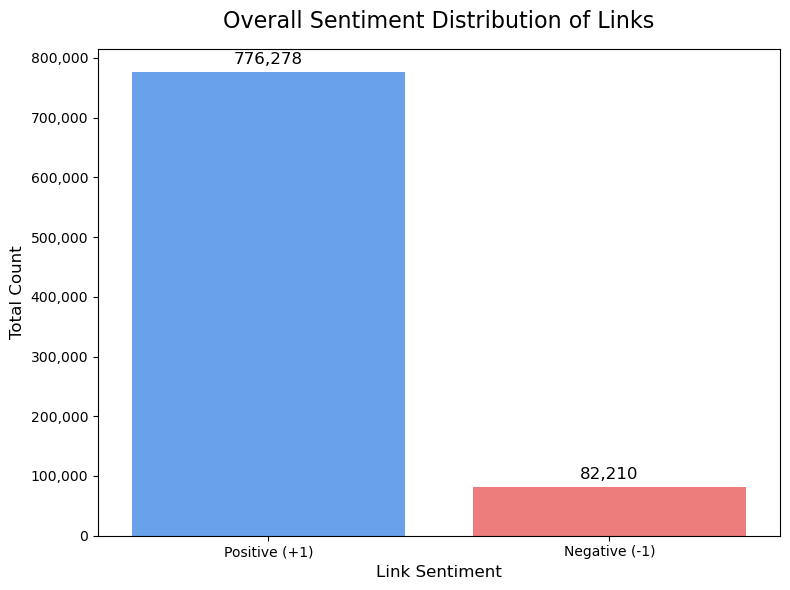

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_sentiment_distribution.png
Generating step1_sentiment_volume_over_time.png...


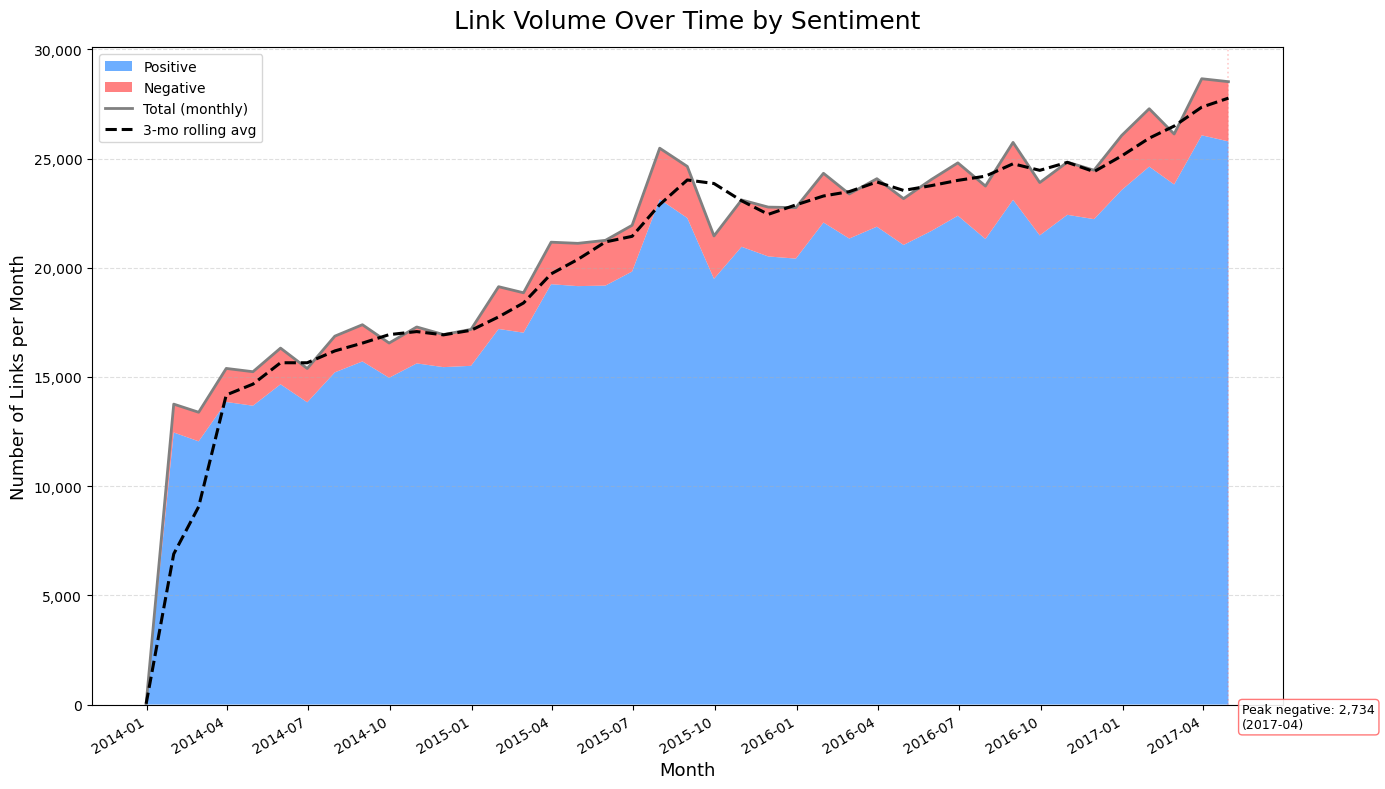

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_sentiment_volume_over_time.png
Generating step1_top_sources.png...


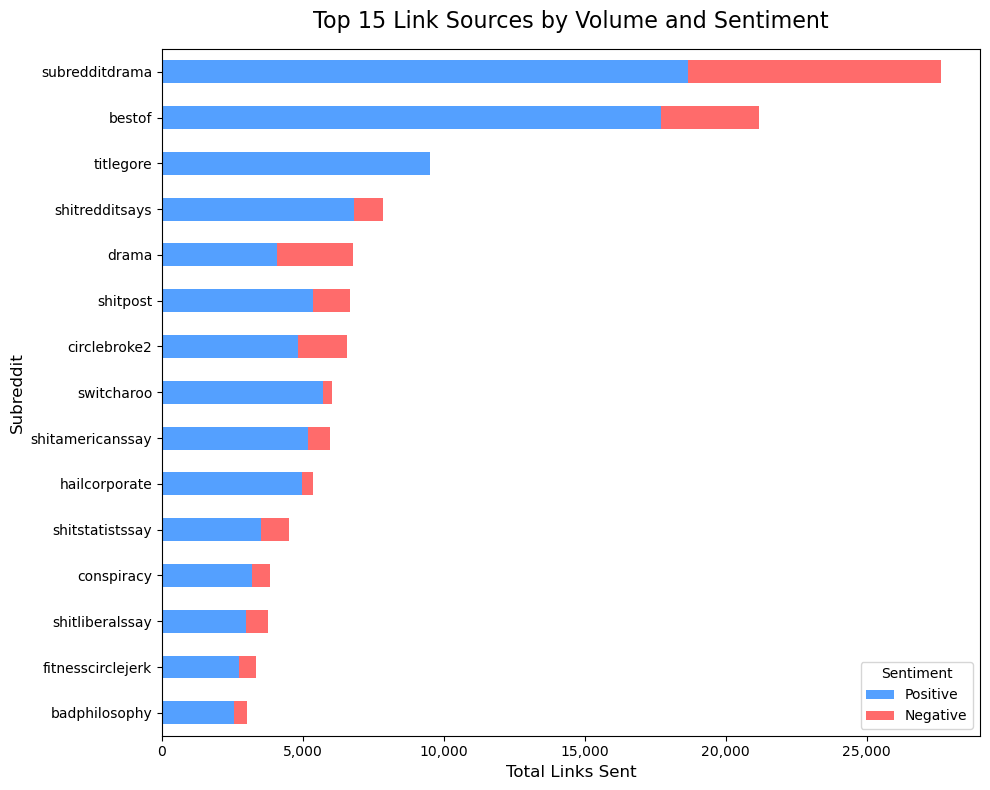

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_top_sources.png
Generating Case Study: r/askreddit vs. r/subredditdrama...
  Comparing r/askreddit (n=1338 links) vs. r/subredditdrama (n=27636 links)
  Setting plot upper limit to: 0.05


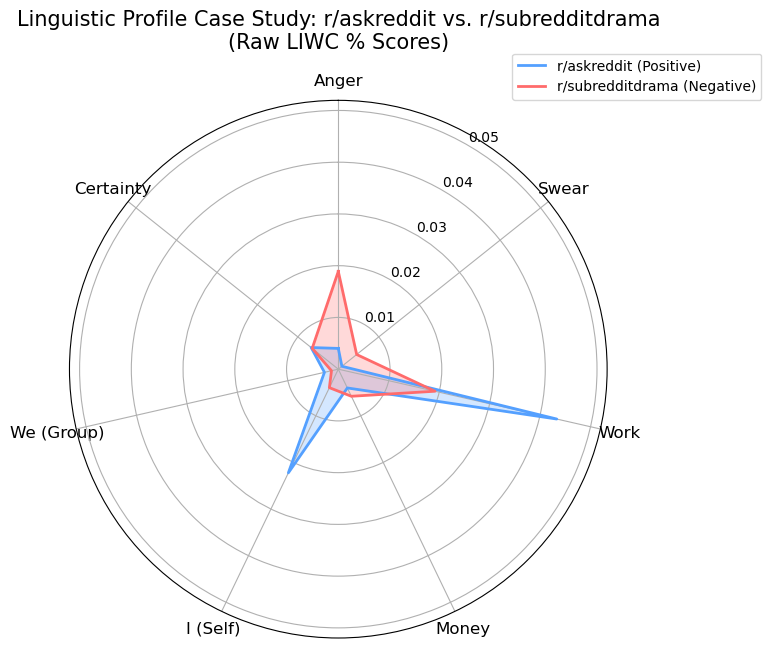

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_liwc_radar_case_study_td_vs_aww.png
Generating step1_top_targets.png...


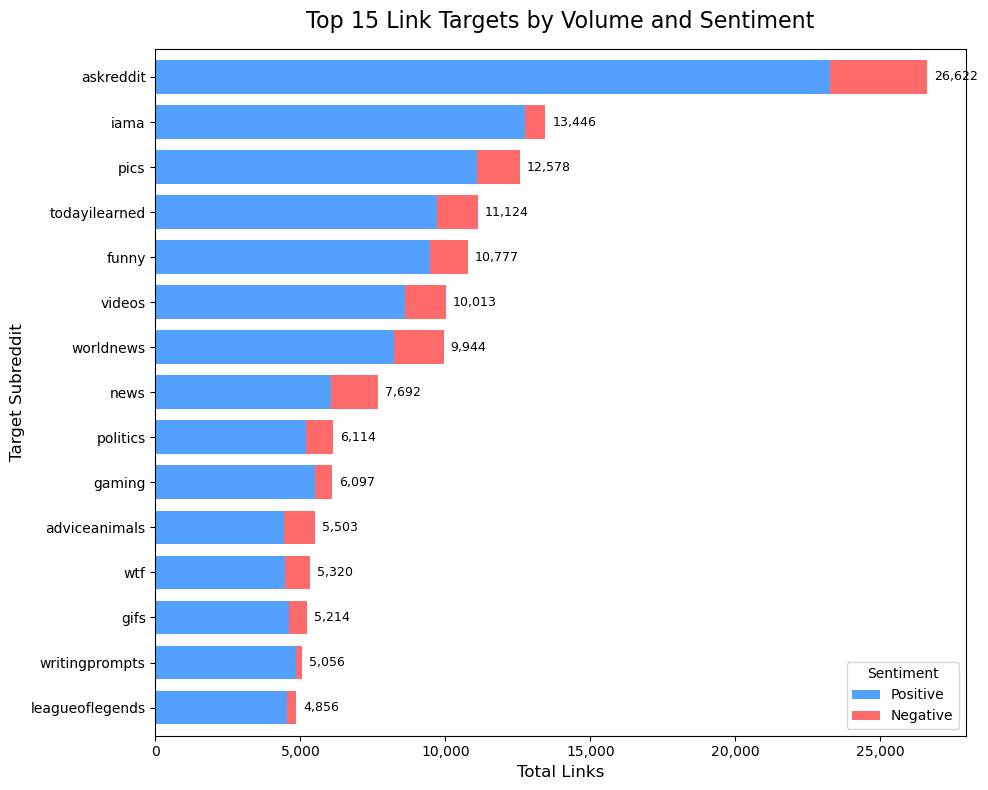

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_top_targets.png
Generating step1_liwc_diverging.png...


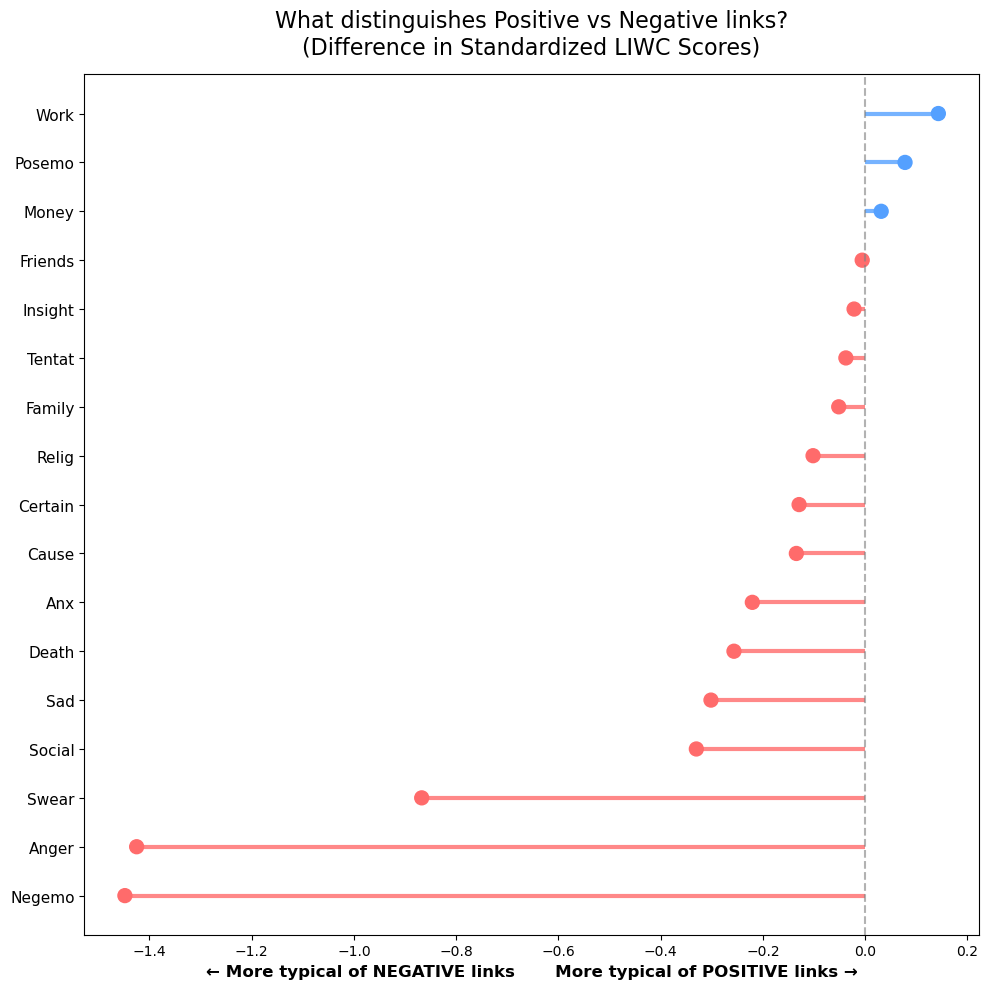

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_liwc_diverging.png
Generating step1_attack_patterns.png...


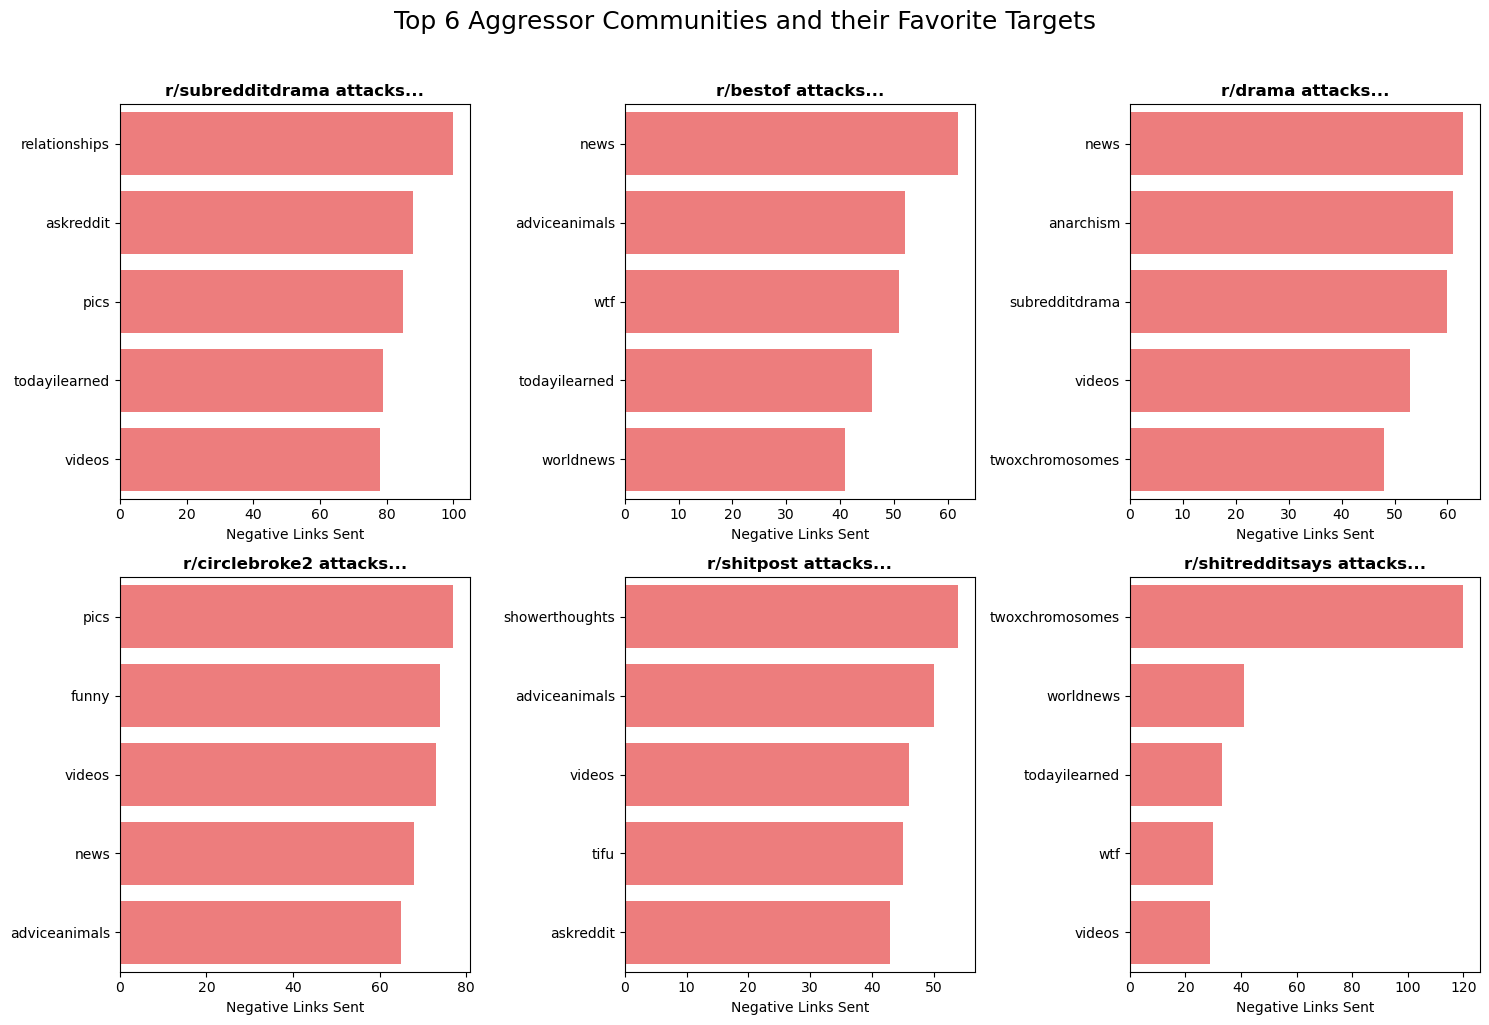

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step1_attack_patterns.png
STEP 1 VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [20]:
hyperlinks_df = load_hyperlinks_data()

if hyperlinks_df is not None:
    
    print("\n Generating Static PNGs (will display below)")
    plot_sentiment_distribution(hyperlinks_df)
    plot_sentiment_volume_over_time(hyperlinks_df)
    plot_top_sources_sentiment(hyperlinks_df)
    plot_liwc_radar_profiles(
        hyperlinks_df, 
        sub_a="askreddit", 
        label_a="Positive", 
        sub_b="subredditdrama", 
        label_b="Negative", 
        save_name="step1_liwc_radar_case_study_td_vs_aww.png"
)
    plot_top_targets_sentiment(hyperlinks_df)
    plot_liwc_diverging_lollipop(hyperlinks_df)
    plot_attack_pattern_small_multiples(hyperlinks_df)
    
            
    print("STEP 1 VISUALIZATION COMPLETE")
    print(f"PNGs saved to: {FIGURES_DIR}")
else:
    print("Stopping visualization pipeline as data could not be loaded.")

### Step 2: Psychological (LIWC) Analysis

**Goal:** Aggregate the 65 LIWC features for *every link* to create psychological profiles for *every subreddit*.

This is the core of our "psychological" layer, handled by `LIWCAnalyzer`. It takes the `combined_hyperlinks.csv` (from Step 1) and calculates average psychological scores for each subreddit, based on the language they use in their outgoing links.

It answers questions like:
* "What is the average 'Anger' score for all links coming from `r/subredditdrama`?"
* "What is the average 'We' (group identity) score for links coming from `r/politics`?"

**About LIWC:** Linguistic Inquiry and Word Count (LIWC) is a validated psycholinguistic dictionary that categorizes words into psychological dimensions (e.g., anger, certainty, cognitive complexity). Each link's PROPERTIES string contains 65 pre-computed LIWC scores. We aggregate these to create subreddit-level psychological fingerprints.

It will generate several new files in `data/processed/`, including:
* `subreddit_features_source.csv`: The average psychological profile for each subreddit's *outgoing* posts.
* `subreddit_features_target.csv`: The average psychological profile for *incoming* posts targeting a subreddit.
* `subreddit_roles.csv`: A classification of subreddits into roles like "Critic," "Target," etc.

In [21]:
print("Initializing LIWCAnalyzer...")
analyzer_liwc = LIWCAnalyzer(
    hyperlinks_df=hyperlinks_df,
    liwc_columns=liwc_columns,
    output_dir=PROCESSED_DIR
)

liwc_results = analyzer_liwc.save_results()

print("\n--- Step 2 Output ---")
print("Successfully generated and saved all LIWC analysis files.")

print("Sample of 'Source Features' (psychology of outgoing links):")
display(liwc_results['source_features'].head())

print("\nSample of 'Target Features' (psychology of incoming links):")
display(liwc_results['target_features'].head())

print("\nTop 15 most discriminating LIWC features (Positive vs Negative Links):")
display(liwc_results['sentiment_comparison'].sort_values('abs_difference', ascending=False).head(15)[
    ['feature', 'positive_mean', 'negative_mean', 'difference']
])


Initializing LIWCAnalyzer...
SAVING RESULTS
\Saving source subreddit features...
AGGREGATING LIWC BY SOURCE SUBREDDIT

 Computing basic statistics...
 Aggregating 65 LIWC features...

 Aggregated 55,863 subreddits
 Features per subreddit: 79
Saving target subreddit features...
AGGREGATING LIWC BY TARGET SUBREDDIT

 Computing basic statistics...
 Aggregating 65 LIWC features...

 Aggregated 34,572 subreddits
 Features per subreddit: 79
Saving sentiment comparison...
COMPARING POSITIVE VS NEGATIVE LINKS

 Sample sizes:
    Positive links:    776,278
    Negative links:     82,210

 Computing differences across 65 features...

Top 15 most discriminating features:
  LIWC_Funct           Pos:   0.30  Neg:   0.35  ↑ Δ:   0.06
  LIWC_Negemo          Pos:   0.01  Neg:   0.06  ↑ Δ:   0.05
  LIWC_Affect          Pos:   0.04  Neg:   0.09  ↑ Δ:   0.05
  LIWC_Anger           Pos:   0.01  Neg:   0.04  ↑ Δ:   0.04
  LIWC_Social          Pos:   0.06  Neg:   0.08  ↑ Δ:   0.02
  LIWC_Verbs           Pos

,subreddit,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_targets,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score
0,007,1,1.0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,07scape,2,1.0,2,0,1,0.385185,0.062834,0.030292,0.002466,0.005096,0.008981,0.001419,0.012866,0.032542,0.054256,0.146542,0.101921,0.010421,0.070471,0.013957,0.032847,0.080685,0.033753,0.009679,0.017144,0.004605,0.0,0.04581,0.0,0.0,0.002117,0.030358,0.019566,0.010793,0.000698,0.005118,0.004976,0.111689,0.012702,0.02559,0.016489,0.02536,0.008839,0.003885,0.021148,0.019173,0.015964,0.009286,0.004212,0.002466,0.00826,0.004561,0.000349,0.0,0.00335,0.118115,0.011283,0.040833,0.067930,0.009396,0.015889,0.007071,0.006024,0.005794,0.002652,0.001419,0.001582,0.003885,0.0,0.002281,0.0,1.0,1.0,0.011918,0.011982,0.033445,0.007352,0.006892
2,07thexpansion,1,1.0,1,0,1,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.047619,0.047619,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.142857,0.000000,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,098f6bcd4621d373,1,1.0,1,0,1,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.033333,0.000000,0.000000
4,0________0,1,1.0,1,0,1,0.400000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0


Sample of 'Target Features' (psychology of incoming links):


,subreddit,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_sources,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score
0,01001111010100000,1,1.0,1,0,1,0.315301,0.047913,0.027821,0.007728,0.012365,0.004637,0.003091,0.003091,0.020093,0.064915,0.064915,0.046368,0.001546,0.027821,0.027821,0.007728,0.089645,0.035549,0.004637,0.017002,0.010819,0.001546,0.068006,0.004637,0.000000,0.007728,0.043277,0.024730,0.018547,0.001546,0.015456,0.000000,0.080371,0.012365,0.009274,0.003091,0.012365,0.006182,0.004637,0.026275,0.007728,0.003091,0.000000,0.000000,0.003091,0.010819,0.007728,0.001546,0.001546,0.000000,0.092736,0.012365,0.034003,0.037094,0.010819,0.013910,0.007728,0.003091,0.010819,0.001546,0.007728,0.000000,0.001546,0.0,0.001546,0.0,1.0,1.0,0.017259,0.020093,0.020608,0.006955,0.007949
1,0131,1,1.0,1,0,1,0.465649,0.114504,0.038168,0.022901,0.000000,0.000000,0.007634,0.015267,0.076336,0.061069,0.145038,0.099237,0.007634,0.106870,0.007634,0.045802,0.083969,0.045802,0.022901,0.030534,0.015267,0.000000,0.053435,0.000000,0.000000,0.007634,0.053435,0.053435,0.000000,0.000000,0.000000,0.000000,0.145038,0.061069,0.015267,0.007634,0.000000,0.022901,0.007634,0.007634,0.030534,0.000000,0.000000,0.000000,0.000000,0.007634,0.007634,0.000000,0.000000,0.000000,0.129771,0.068702,0.022901,0.038168,0.015267,0.015267,0.007634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.017812,0.015267,0.041985,0.009542,0.005453
2,07scape,3,1.0,3,0,1,0.468709,0.093015,0.050420,0.026426,0.002991,0.016359,0.000669,0.004309,0.042594,0.065733,0.099667,0.052300,0.020943,0.066715,0.002991,0.049480,0.122157,0.062867,0.017072,0.027196,0.003995,0.000983,0.063951,0.000000,0.001004,0.004644,0.049978,0.028618,0.020377,0.000983,0.011360,0.001967,0.154896,0.020879,0.024143,0.016088,0.033974,0.008577,0.002008,0.035668,0.030712,0.017553,0.010314,0.002301,0.002971,0.012950,0.011632,0.000983,0.000000,0.000335,0.127493,0.019541,0.065211,0.037992,0.019016,0.020272,0.012552,0.000335,0.017803,0.001339,0.002008,0.001987,0.009833,0.0,0.000983,0.0,1.0,1.0,0.018880,0.017400,0.043093,0.012521,0.010475
3,093game,1,1.0,1,0,1,0.260870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.043478,0.000000,0.043478,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.043478,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.010870,0.014493,0.000000,0.006211
4,0b0t,1,1.0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Top 15 most discriminating LIWC features (Positive vs Negative Links):


,feature,positive_mean,negative_mean,difference
0,LIWC_Funct,0.295647,0.352010,0.056363
28,LIWC_Negemo,0.011705,0.062464,0.050759
26,LIWC_Affect,0.038172,0.085882,0.047710
30,LIWC_Anger,0.005176,0.042650,0.037474
22,LIWC_Social,0.061566,0.081984,0.020418
10,LIWC_Verbs,0.066732,0.084556,0.017824
32,LIWC_CogMech,0.095646,0.112553,0.016907
45,LIWC_Bio,0.017195,0.033414,0.016220
13,LIWC_Present,0.042945,0.058868,0.015923
21,LIWC_Swear,0.001614,0.016292,0.014679


### Step 2 Visualizations: Psychological & Role Profiles
We now visualize the aggregated psychological profiles to see how communities are perceived and how they behave.

* **`plot_psychological_asymmetry`**: A plot showing the gap between the language a sub *uses* (e.g., outgoing anger) vs. the language *used against it* (incoming anger).
* **`plot_role_quadrant_map`**: Our main "social roles" scatter plot, mapping subreddits into four quadrants (e.g., "Critical," "Supportive," "Controversial") based on their link behavior.
* **`plot_top_influential`**: A bar chart ranking the Top 10 "Influential" subreddits, which are defined by their high volume of positive outgoing links.
* **`plot_top_supported`**: A bar chart ranking the Top 10 "Supported" subreddits, which are defined by their high volume of positive incoming links.

Loading LIWC Analysis Data ---
Generating step2_anger_asymmetry.png...


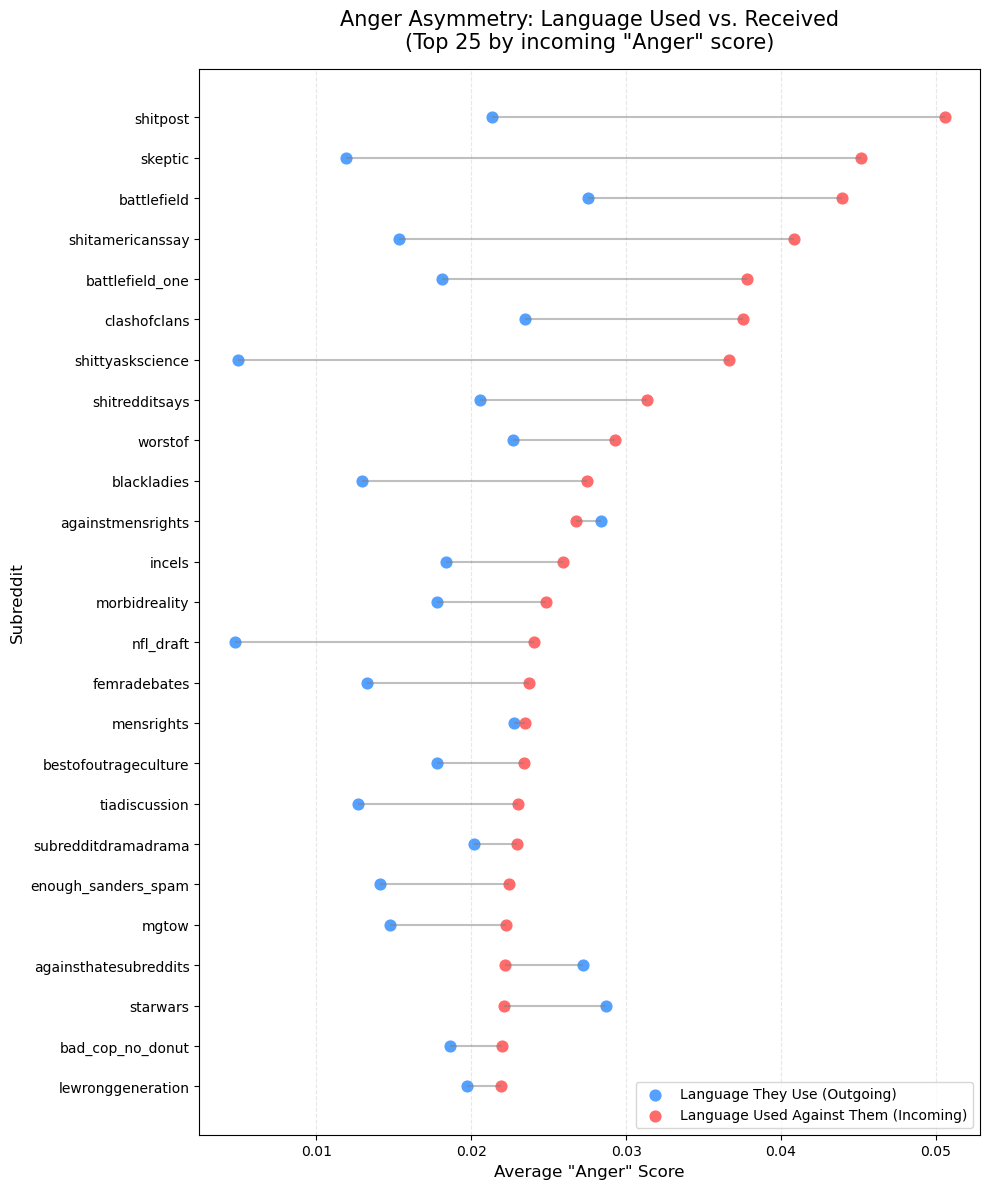

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step2_anger_asymmetry.png
Generating step2_role_quadrant.png...


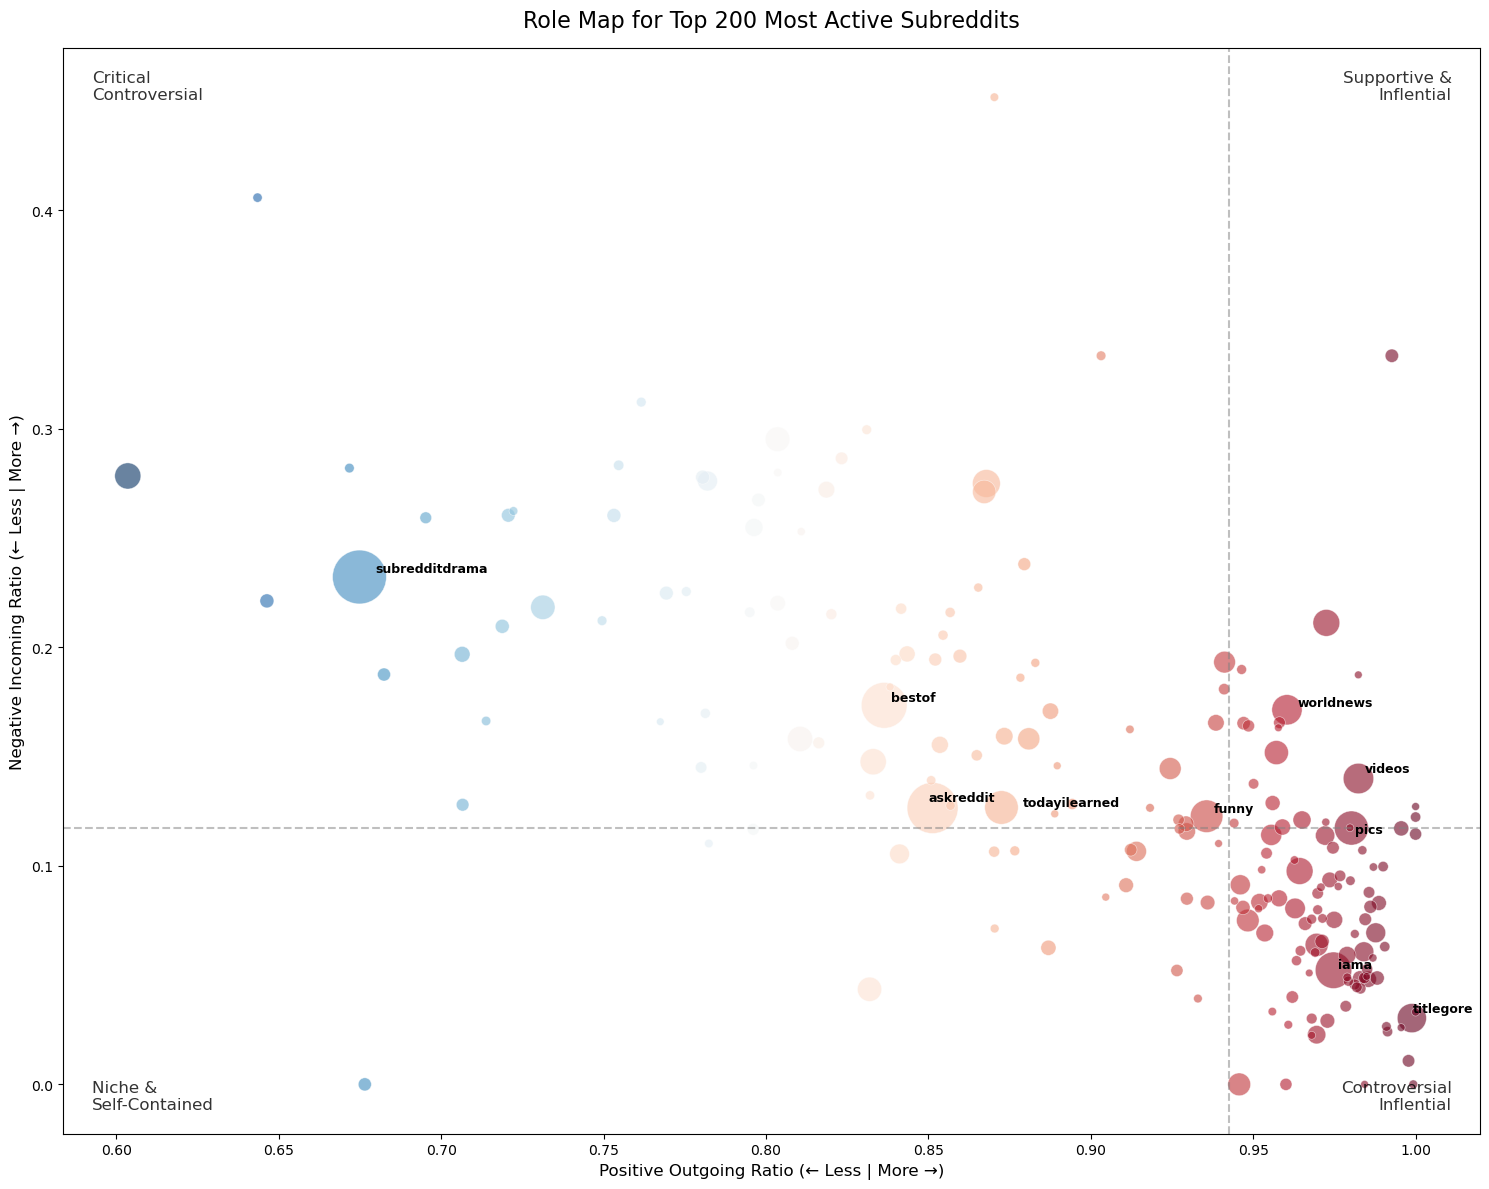

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step2_role_quadrant.png
Generating step2_top_influential.png...


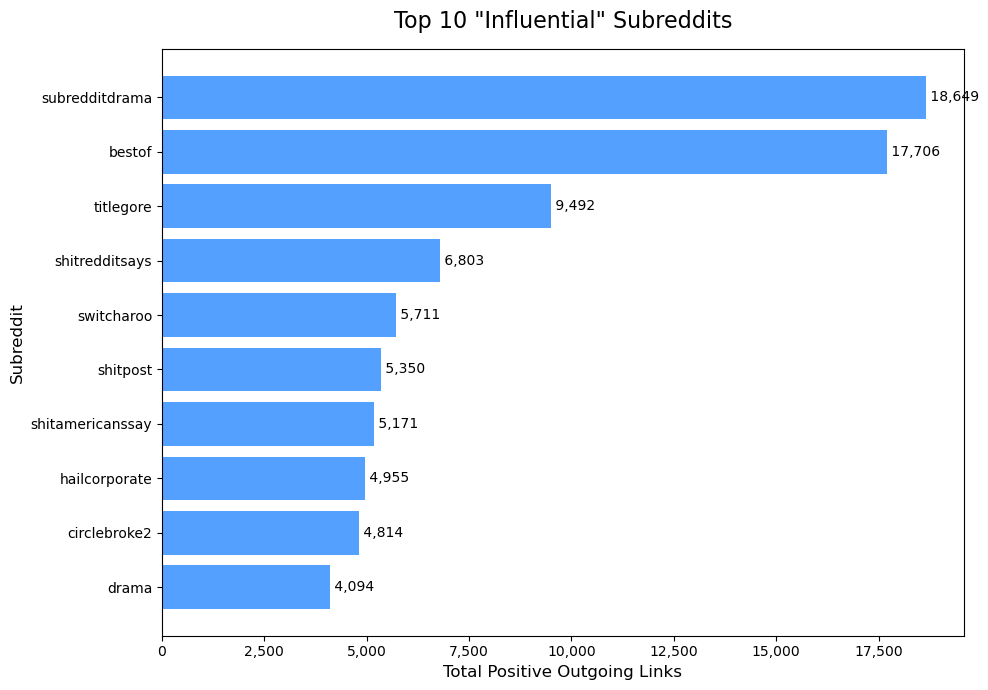

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step2_top_influential.png
Generating step2_top_supported.png...


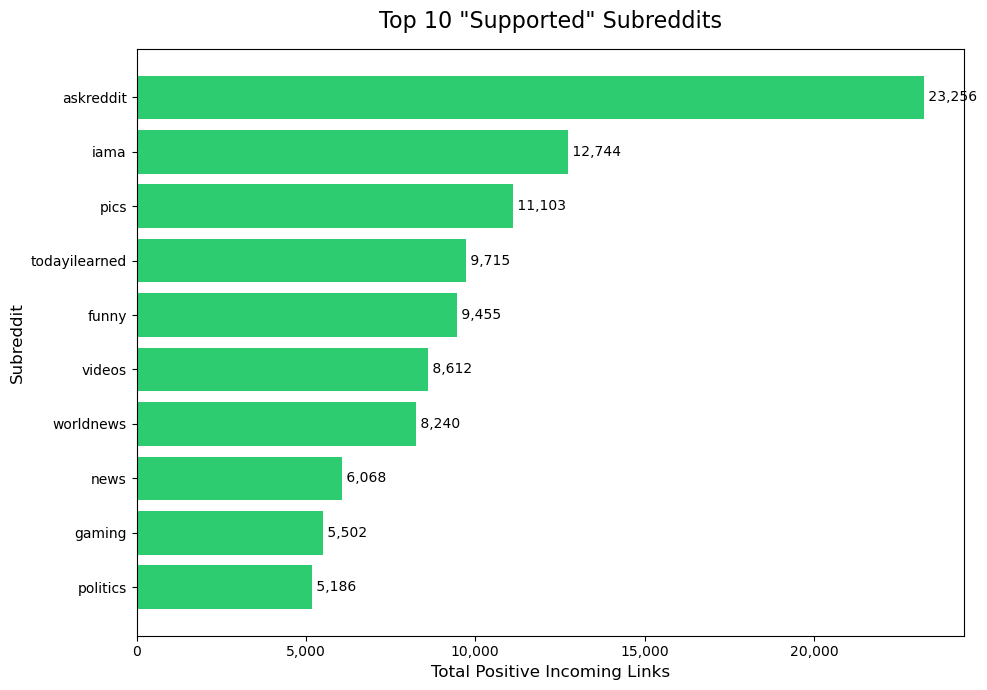

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step2_top_supported.png

STEP 2 LIWC VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [22]:
print("Loading LIWC Analysis Data ---")
df_sent_comp = load_liwc_sentiment_comparison()
df_roles = load_subreddit_roles()
df_profiles = load_psychological_profiles()

if df_roles is not None:
    plot_psychological_asymmetry(df_roles)
else:
    print("Skipping Role Map and Asymmetry plots: 'subreddit_roles.csv' not found.")
    
if df_roles is not None:
    plot_role_quadrant_map(df_roles)
    plot_top_influential(df_roles)
    plot_top_supported(df_roles)
else:
    print("Skipping Heatmap plot: 'psychological_profiles.csv' not found.")

print("\nSTEP 2 LIWC VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 3: Network Structure Analysis

**Goal:** Build the actual graph of Reddit communities to understand the structural properties of the ecosystem.

**Key Metrics:**
- **PageRank:** Measures prestige (who gets linked to)
- **Betweenness Centrality:** Measures bridging (who connects disconnected communities). We use k=50 sampling for computational efficiency,sufficient for ranking communities, though absolute values are approximations.
- **Hub/Authority Scores:** Measures linkers vs linked-to communities
- **Louvain Communities:** Detects structural clusters (independent of topic)

This step, handled by `NetworkAnalyzer`, takes our `combined_hyperlinks.csv` (from Step 1) and constructs a `networkx` graph. It then performs several critical network science analyses:

1.  **Build Graphs:** Creates a main directed graph, plus separate graphs for only positive and only negative links.
2.  **Node Metrics:** Calculates centrality scores for every subreddit (PageRank, Betweenness, Hubs & Authorities).
3.  **Community Detection:** Uses the Louvain algorithm to find clusters of subreddits that are densely connected to each other, regardless of their topic.

The output below shows centrality rankings:
- **PageRank top 10:** The most prestigious communities (frequently linked-to)
- **Betweenness top 10:** The bridges connecting different parts of Reddit
- **Hub/Authority scores:** Communities that link frequently vs get linked frequently

This gives us our "Structural" features (`network_node_metrics.csv` and `network_communities.csv`).

In [23]:
print("Initializing NetworkAnalyzer...")
analyzer_network = NetworkAnalyzer(
    hyperlinks_df=hyperlinks_df,
    output_dir=PROCESSED_DIR
)

# Build the networks first
analyzer_network.build_networks()

network_results = analyzer_network.save_results()

# --- Show Results ---
print("\n--- Step 3 Output ---")
print("Successfully generated and saved all Network analysis files.")

print("\nBasic Network Stats:")
display(network_results['stats'])

print("\nSample of 'Node Metrics' (PageRank, Centrality, etc.):")
display(network_results['metrics'].sort_values('pagerank', ascending=False).head())

print("\nTop 5 Largest Communities found by Louvain:")
display(network_results['communities']['community'].value_counts().head(5))

Initializing NetworkAnalyzer...

 Building main directed network...
 Nodes:     67,180
 Edges:    339,643

 Building positive-only network...
Nodes:     65,892
Edges:    321,539

 Building negative-only network...
Nodes:     12,069
Edges:     41,170
Building undirected network for community detection...
SAVING NETWORK RESULTS

 Saving basic statistics...
BASIC NETWORK STATISTICS

 Network Overview:
    Nodes:                  67,180
    Edges:                 339,643
    Density:              0.000075
    Reciprocity:             0.177

  Weakly connected:          712
    Strongly connected:     45,564
    Largest component:      65,648 ( 97.7%)

 Degree Statistics:
    In-degree  - Mean:     5.06, Median:      1, Max:   5448
    Out-degree - Mean:     5.06, Median:      1, Max:   3111
 Saving node metrics...
COMPUTING NODE METRICS

 Computing metrics for 67,180 nodes...
Degree centrality...
PageRank...
HITS (hubs and authorities)...
Betweenness centrality (Approximation k=50)...
Samp

{'n_nodes': 67180,
 'n_edges': 339643,
 'density': 7.525738678606207e-05,
 'n_weakly_connected_components': 712,
 'n_strongly_connected_components': 45564,
 'largest_component_size': 65648,
 'largest_component_fraction': 0.9771955939267639,
 'reciprocity': 0.1765147522545732}


Sample of 'Node Metrics' (PageRank, Centrality, etc.):


,subreddit,in_degree,out_degree,total_degree,in_weight,out_weight,total_weight,in_degree_centrality,out_degree_centrality,pagerank,hub_score,authority_score,betweenness,clustering,avg_in_sentiment,avg_out_sentiment,n_positive_in,n_negative_in,n_positive_out,n_negative_out,neg_in_ratio,neg_out_ratio
7,askreddit,5448,363,5811,26622,1338,27960,0.081097,0.005403,0.022047,0.003534,0.022474,0.045118,0.007450,0.818591,0.765507,23256,3366,1139,199,0.126437,0.148729
25,iama,4508,387,4895,13446,1187,14633,0.067104,0.005761,0.017709,0.001468,0.008558,0.021181,0.009267,0.923402,0.961794,12744,702,1157,30,0.052209,0.025274
26,pics,3335,169,3504,12578,253,12831,0.049643,0.002516,0.011252,0.000278,0.018867,0.011487,0.014273,0.853036,0.975345,11103,1475,248,5,0.117268,0.019763
259,funny,3031,472,3503,10777,979,11756,0.045118,0.007026,0.010050,0.002102,0.016711,0.012727,0.015727,0.816140,0.860227,9455,1322,916,63,0.122669,0.064351
90,videos,2644,242,2886,10013,341,10354,0.039358,0.003602,0.009317,0.000318,0.016987,0.011978,0.019863,0.818067,0.975010,8612,1401,335,6,0.139918,0.017595



Top 5 Largest Communities found by Louvain:


community
3     11000
5      6990
6      6703
10     3901
30     3766
Name: count, dtype: int64

### Step 3 Visualizations: Network Centrality
This visualization shows the results of our network analysis, identifying the most influential "hubs," "authorities," and "bridges" in the network.

* **`plot_centrality_grid`**: A bar charts displaying the "Top 15" subreddits ranked by our four key centrality metrics: **PageRank** (prestige), **Betweenness** (bridges), **Hub Score** (good linkers), and **Authority Score** (good content).

Loading Network Analysis Data
Generating step3_centrality_grid.png...


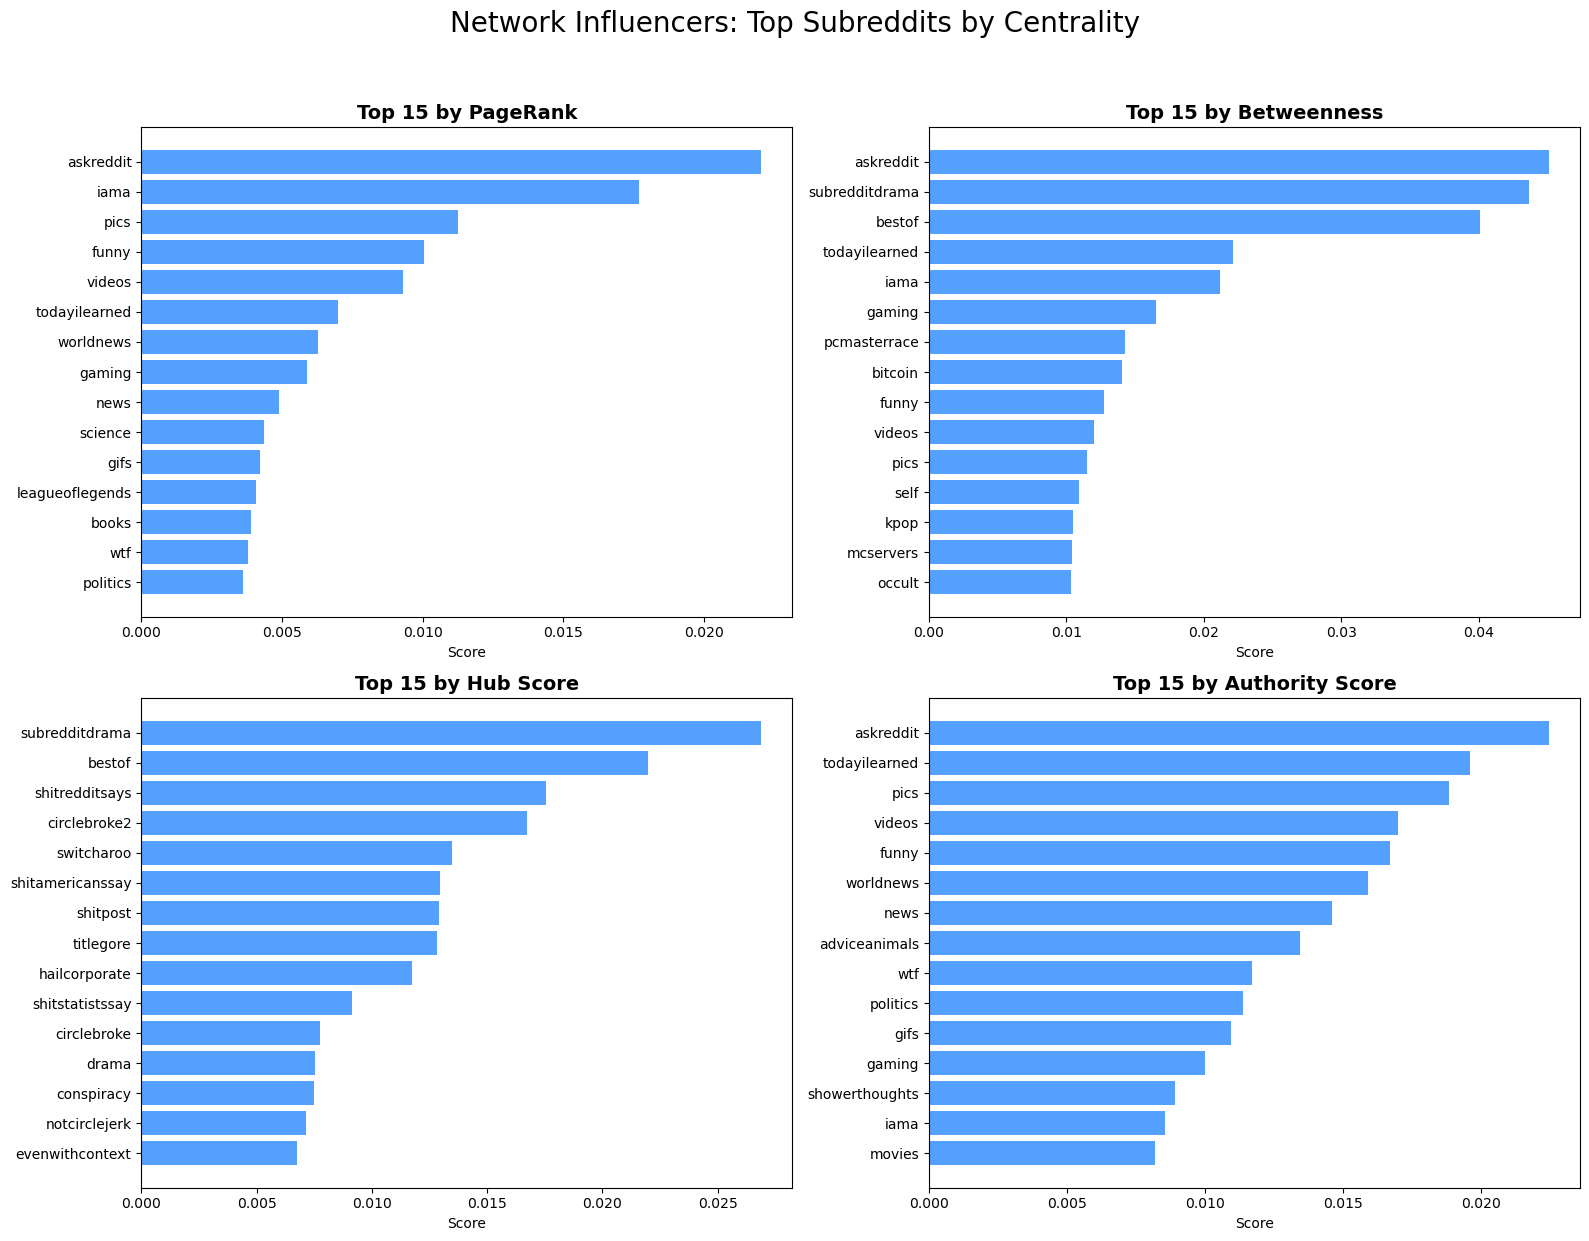

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step3_centrality_grid.png

STEP 3 NETWORK VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [24]:
print("Loading Network Analysis Data")
df_metrics = load_network_metrics()
df_communities = load_network_communities()

if df_metrics is not None:
    plot_centrality_grid(df_metrics)
else:
    print("Skipping Centrality Grid: 'network_node_metrics.csv' not found.")

print("\nSTEP 3 NETWORK VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 4: Embedding Processing (Semantic Analysis)

**Goal:** Load the 300-dimensional subreddit embeddings (`web-redditEmbeddings-subreddits.csv`) to understand the *content* and *topic* of each community.

This step, handled by `EmbeddingProcessor`, does the essential feature engineering:
1.  **Loads & Validates** the 51k+ embedding vectors.
2.  **Runs PCA (Principal Component Analysis):** It reduces the 300 embedding dimensions down to 50, capturing the most important semantic information (e.g., `pca_0`, `pca_1`...). This creates the "Semantic" features for our final dataset.
3.  **Saves** the result to `embeddings_processed.csv`.


In [25]:
(embeddings_df, pca_model) = process_embeddings(
    embeddings_path=EMBEDDINGS_PATH,
    output_dir=PROCESSED_DIR
)

# Show Results
print("\n--- Step 4 Output ---")
print(f"PCA model explains {np.sum(pca_model.explained_variance_ratio_)*100:.2f}% of variance with 50 components.")

print("\nSample of processed embedding data (with new PCA columns):")
display(embeddings_df.head())

Embedding Processing....
Loading.....
Raw shape: (51278, 301)
 Columns: 1 subreddit + 300 embedding dimensions
 Removed 0 duplicate subreddits

 Loaded embeddings for 51,278 subreddits
Embedding validation
 No missing values

 Embedding statistics:
    Mean:   -0.001681
    Std:    0.146797
    Min:    -5.268686
    Max:    5.467387
PCA Dimensionality Reduction....

 Computing PCA (50 components)...

 Variance explained:
All 50 components: 92.2%

 Saved processed embeddings: /home/hamza/ada-2025-project-barrada/data/processed/embeddings_processed.csv
 Embedding Processing Complete

--- Step 4 Output ---
PCA model explains 92.19% of variance with 50 components.

Sample of processed embedding data (with new PCA columns):


,subreddit,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
0,spiders,0.158972,0.285813,0.226329,-0.183338,-0.163159,-0.188910,0.422705,0.168602,0.178193,-0.149062,-0.300842,0.250692,-0.094018,-0.137390,0.481468,0.142735,0.162125,-0.457625,-0.005093,-0.273027,-0.337085,-0.217706,-0.330685,0.007393,0.169097,0.116136,0.546717,-0.038156,0.067753,0.275081,0.890474,-0.109753,0.043334,0.640792,0.673051,0.476472,-0.030415,0.066892,0.471129,-0.339831,-0.747467,-0.109928,0.416121,-0.350133,0.712881,0.171884,0.918882,-0.061754,0.548397,0.208283,0.193454,-0.528931,-0.157124,0.121313,1.057225,-0.230851,0.714269,-0.200375,0.109928,0.026177,-0.820041,-0.060443,0.745277,0.006133,-0.335152,-0.153250,-0.425811,-0.446891,-0.398313,-0.155923,0.571123,0.241867,0.012326,-0.141842,-0.452672,0.106994,-0.293534,-0.406696,0.063992,0.147539,0.050882,-0.206677,-0.009601,0.303460,0.103411,0.474364,-0.317152,-0.002853,-0.429201,0.249675,-0.084892,-0.208370,-0.997411,-0.004180,0.515307,0.270712,-0.169075,-0.073621,-0.287748,0.203007,0.037525,-0.009384,-0.251375,0.111070,0.186933,0.523963,0.552564,0.286402,0.122608,0.741214,-0.318127,0.312066,0.009872,0.008895,0.066247,0.007472,0.215160,-0.206872,0.000868,0.261308,0.081798,0.414977,0.098206,-0.616977,0.318122,-0.010342,-0.142088,-0.788810,0.513688,0.098844,-0.020168,-0.037938,-0.325909,-0.585896,-0.416931,0.106078,-0.142849,-0.036123,-0.865125,-0.197684,0.123392,0.405778,-0.21

### Step 4 Visualizations: Semantic Space (PCA)
This plot validates our semantic processing and dimensionality reduction.

* **`plot_pca_variance`**: A plot showing the cumulative variance explained by our 50 Principal Components. This confirms that 50 components are a good choice, as they capture the vast majority (~90%) of the information from the original 300 embedding dimensions.

Generating step4_pca_variance.png...
Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step4_pca_variance.png
STEP 4 VISUALIZATION COMPLETE
PNGs saved to: results/figures


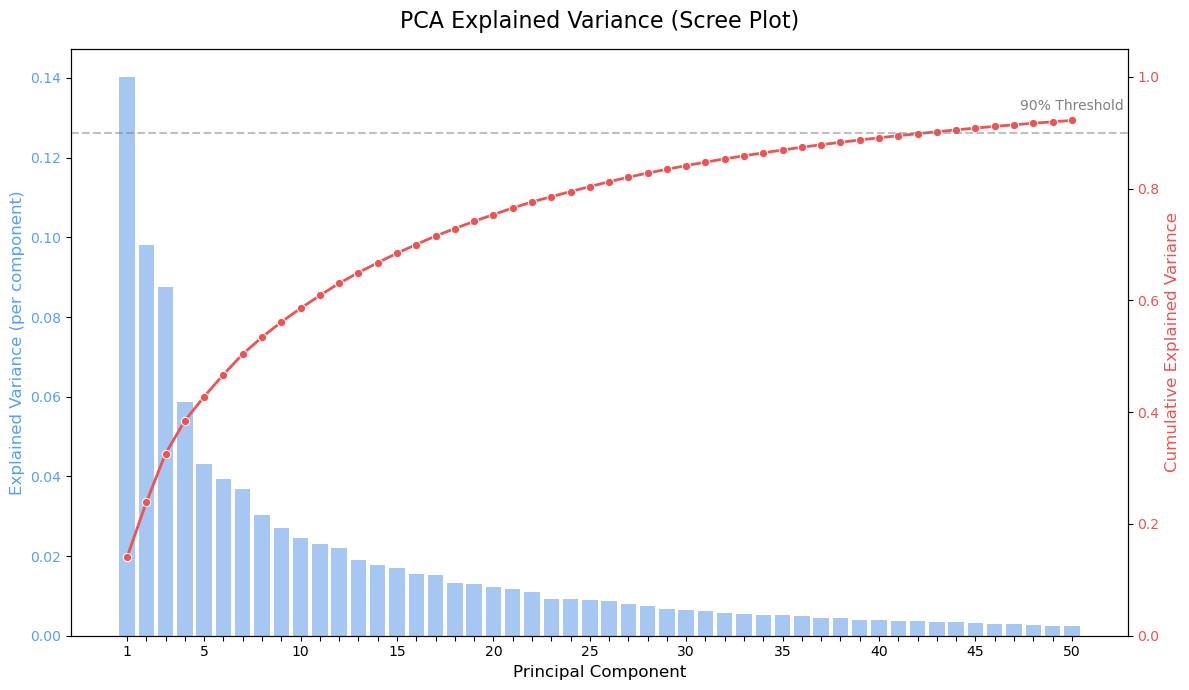

In [26]:
pca_var_df = load_pca_variance_data()
embeddings_df = load_embeddings_data()

if pca_var_df is not None and embeddings_df is not None:
    
    plot_pca_variance(pca_var_df)
        
    print("STEP 4 VISUALIZATION COMPLETE")
    print(f"PNGs saved to: {FIGURES_DIR}")
else:
    print("Stopping visualization pipeline as Step 4 data could not be loaded.")

### Step 5 Topic Clustering (Semantic Content)

**Goal:** : Run K-Means clustering (`K=40`) on the 300-dimensional subreddit embeddings to assign a **Topic Cluster ID** and a **manual label** to each community.

**Why K=40?** We tested K=20, K=40, and K=50. While K=50 had better silhouette scores (0.23 vs 0.19), the resulting clusters were semantically incoherent (e.g., mixing gaming and politics). K=40 provides the best balance between statistical fit and interpretability.

**Manual Labeling Process:**
1. Run K-Means to assign 51,278 subreddits to 40 clusters
2. For each cluster, examine top-20 subreddits by link volume
3. Manually assign semantic labels (e.g., "Gaming," "Politics," "Meta-Commentary")
4. Apply 66 manual overrides to fix edge cases (e.g., r/steam misclassified with cooking communities)

**Output:** Each subreddit gets a `topic_cluster_id` (0-39) and a human-readable `topic_label`.

This step generates `embeddings_kmeans_topic_40.csv`, which provides the **third, distinct dimension (Content/Topic)** for our integrated analysis.

In [27]:
# Run clustering (or reload if already saved inside the function)
df_clusters = run_topic_clustering(
    embeddings_path="data/subreddit_embeddings/web-redditEmbeddings-subreddits.csv",
    output_dir="data/processed"
)

# --- Show basic results ---
print("\n--- Step 5 Output ---")
print("Successfully generated and saved Topic Clustering results.\n")


Loading raw embeddings...
Running K-Means clustering (K=40) on 51278 subreddits...
  Clustering complete
  Silhouette (Cosine): 0.0552
  Davies-Bouldin: 2.4361

Applying 66 hardcoded overrides...
  Total subreddits re-classified: 64

 Topic clusters saved to: data/processed/embeddings_kmeans_40.csv
 Cluster label map saved to: data/processed/cluster_labels_40.csv

Top 10 CENTRAL members per cluster (Closest to mathematical centroid):

Cluster: Art/Imaginary - 271 members
  Top 10 Central:
    1. imaginarycolorscapes
    2. imaginarygiants
    3. imaginarydwarves
    4. imaginarywaterfalls
    5. imaginaryderelicts
    6. imaginaryvampires
    7. imaginaryelementals
    8. imaginarystarships
    9. imaginarypirates
    10. imaginaryvillages

Cluster: Celebrities/Models - 623 members
  Top 10 Central:
    1. emilyratajkowski
    2. gigi_hadid
    3. jessicaalba
    4. vanessahudgens
    5. oliviamunn
    6. amanda_seyfried
    7. maitlandward
    8. bellahadid
    9. avasambora
    10. d

### Step 5 Visualizations: Topic Cluster Analysis
This plot visualizes the output of our K-Means clustering.

* **`plot_topic_cluster_distribution`**: A horizontal bar chart showing the size (i.e., number of subreddits) of each of our 40 manually-labeled topic clusters. This helps us immediately identify which topics are large, dominant themes (like 'Games' or 'Politics') and which are small, niche categories.

--- Loading Topic Clustering Data ---

--- Generating Static PNGs (will display below) ---
Generating step5_topic_distribution.png...


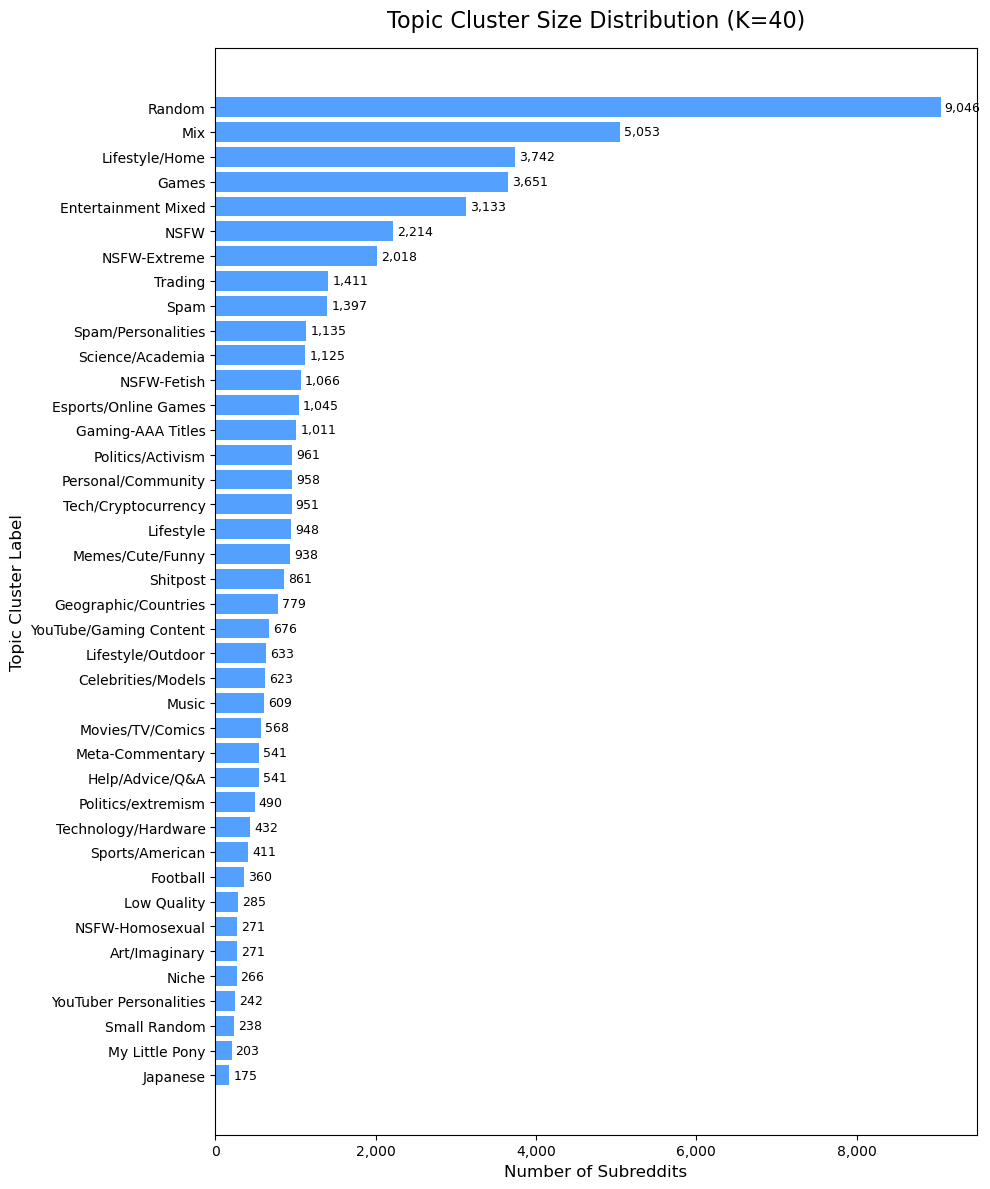

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step5_topic_distribution.png

STEP 5 TOPIC CLUSTERING VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [28]:
# --- Step 5: Topic Clustering Visualizations ---
print("--- Loading Topic Clustering Data ---")
df_clusters = load_topic_clusters()

# We also need the PCA data from Step 2
df_embeddings = load_embeddings_data() 

# --- Generate Static PNGs ---
print("\n--- Generating Static PNGs (will display below) ---")

if df_clusters is not None:
    plot_topic_cluster_distribution(df_clusters)
else:
    print("Skipping Topic Distribution plot: 'embeddings_kmeans_40.csv' not found.")

print("\nSTEP 5 TOPIC CLUSTERING VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 6: Data Integration (The Final Merge)

**Goal:** Combine all our processed files (`network_metrics`, `embeddings_processed`, `liwc_features`, `communities`, `roles`) into a single, analysis-ready "master" dataset: `final_dataset.csv`.

This step, handled by `DataIntegrator`, is the final and most critical part of the pipeline. It joins all data sources on the `subreddit` key that integrate the structural, semantic, and psychological data.

This process will:
1.  **Load** all the CSVs from `data/processed/`.
2.  **Merge** them using `subreddit` as the key.
3.  **Save** the final `final_dataset.csv` to explain all 150+ columns.

In [29]:
print("Initializing DataIntegrator...")
integrator = DataIntegrator(
    processed_dir=PROCESSED_DIR
)

# Run the full integration pipeline
final_df = integrator.run()

print(f"\nFinal Dataset Shape: {final_df.shape}")

print("\nSample of the final, integrated dataset:")
display(final_df.head())


Initializing DataIntegrator...
Integration Pipeline...
LOADING....

 Loading network metrics...
  67,180 nodes * 22 features
 Loading LIWC source features...
 55,863 subreddits * 79 features
Loading LIWC target features...
  34,572 subreddits * 79 features
 Loading embeddings...
  51,278 subreddits * 351 features
 Loading community assignments...
 67,180 subreddits
 Loading psychological roles...
  67,180 subreddits * 166 features
  Roles columns: ['subreddit', 'n_links_out', 'avg_sentiment_out', 'n_positive_links_out', 'n_negative_links_out', 'n_unique_targets', 'LIWC_Funct_mean_out', 'LIWC_Pronoun_mean_out', 'LIWC_Ppron_mean_out', 'LIWC_I_mean_out', 'LIWC_We_mean_out', 'LIWC_You_mean_out', 'LIWC_SheHe_mean_out', 'LIWC_They_mean_out', 'LIWC_Ipron_mean_out', 'LIWC_Article_mean_out', 'LIWC_Verbs_mean_out', 'LIWC_AuxVb_mean_out', 'LIWC_Past_mean_out', 'LIWC_Present_mean_out', 'LIWC_Future_mean_out', 'LIWC_Adverbs_mean_out', 'LIWC_Prep_mean_out', 'LIWC_Conj_mean_out', 'LIWC_Negate_mean_ou

,subreddit,in_degree,out_degree,total_degree,in_weight,out_weight,total_weight,in_degree_centrality,out_degree_centrality,pagerank,hub_score,authority_score,betweenness,clustering,avg_in_sentiment,avg_out_sentiment,n_positive_in,n_negative_in,n_positive_out,n_negative_out,neg_in_ratio,neg_out_ratio,n_links,avg_sentiment,n_positive_links,n_negative_links,n_unique_targets,LIWC_Funct_mean,LIWC_Pronoun_mean,LIWC_Ppron_mean,LIWC_I_mean,LIWC_We_mean,LIWC_You_mean,LIWC_SheHe_mean,LIWC_They_mean,LIWC_Ipron_mean,LIWC_Article_mean,LIWC_Verbs_mean,LIWC_AuxVb_mean,LIWC_Past_mean,LIWC_Present_mean,LIWC_Future_mean,LIWC_Adverbs_mean,LIWC_Prep_mean,LIWC_Conj_mean,LIWC_Negate_mean,LIWC_Quant_mean,LIWC_Numbers_mean,LIWC_Swear_mean,LIWC_Social_mean,LIWC_Family_mean,LIWC_Friends_mean,LIWC_Humans_mean,LIWC_Affect_mean,LIWC_Posemo_mean,LIWC_Negemo_mean,LIWC_Anx_mean,LIWC_Anger_mean,LIWC_Sad_mean,LIWC_CogMech_mean,LIWC_Insight_mean,LIWC_Cause_mean,LIWC_Discrep_mean,LIWC_Tentat_mean,LIWC_Certain_mean,LIWC_Inhib_mean,LIWC_Incl_mean,LIWC_Excl_mean,LIWC_Percept_mean,LIWC_See_mean,LIWC_Hear_mean,LIWC_Feel_mean,LIWC_Bio_mean,LIWC_Body_mean,LIWC_Health_mean,LIWC_Sexual_mean,LIWC_Ingest_mean,LIWC_Relativ_mean,LIWC_Motion_mean,LIWC_Space_mean,LIWC_Time_mean,LIWC_Work_mean,LIWC_Achiev_mean,LIWC_Leisure_mean,LIWC_Home_mean,LIWC_Money_mean,LIWC_Relig_mean,LIWC_Death_mean,LIWC_Assent_mean,LIWC_Dissent_mean,LIWC_Nonflu_mean,LIWC_Filler_mean,negativity_ratio,positivity_ratio,sentiment_balance,Emotion_score,Social_score,Cognitive_score,Pronouns_score,Drives_score,n_unique_sources_target,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,topic_cluster,topic_cluster_label,community,role_critical,role_controversial,role_supportive,role_influential,pos_out_ratio,pos_in_ratio,total_links
0,007,0,1,1,0,1,1,0.000000,0.000015,0.000003,-2.431388e-27,-0.000000e+00,0.0,0.000000,0.000000,1.0,0,0,1,0,0.000000,0.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.457179,0.041657,0.042331,-0.341856,0.166867,-0.630364,1.358712,0.475806,1.078077,0.774417,-0.722479,-0.287459,0.719648,1.098677,0.040047,-0.967836,0.108851,0.133295,-0.536382,-0.475698,-0.130795,-0.196897,1.292235,0.291428,-1.140331,-0.876514,0.040021,-0.921984,0.321784,0.840899,0.252413,0.153226,-0.592188,-1.007293,0.320643,-0.758674,-0.324670,-0.252617,-0.132309,0.361147,-0.212963,-0.544888,0.138983,0.040942,-0.506035,0.031042,0.235128,-0.300202,0.030463,-0.514387,17.0,Movies/TV/Comics,0,False,False,False,False,1.0,0.000000,1.0
1,daniel_craig,1,0,1,1,0,1,0.000015,0.000000,0.000006,-0.000000e+00,-7.279487e-24,0.0,0.000000,1.000000,0.0,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Step 6 Visualizations: The 3-Layer Integration
These are the final plots that merge all three layers of our data (Semantic, Psychological, and Structural) to answer our core research questions.

* **`plot_topic_network_role`**: A plot that shows the average network sentiment (incoming vs. outgoing) for each of our 40 *topic clusters*. This helps identify which topics are "net-positive" or "net-negative" in the ecosystem.

* **`plot_liwc_role_lift`**: We run two heatmaps. They show the "lift," or percentage increase, in psychological language or each of our defined social roles. This lets us create a linguistic fingerprint for "Critical," "Controversial," "Supportive," and "Influential" communities.

* **`plot_semantic_structural_heatmap`**: Our key "echo chamber" plot. It's a heatmap that compares **Topics (semantic rows)** with **Network Groups (structural columns)**. A bright square on a row reveals a topic cluster that is also an insular, self-linking network and thus an **echo chamber**

--- Loading All Final Datasets ---
Loading final dataset from /home/hamza/ada-2025-project-barrada/data/processed/final_dataset.csv...
Loaded 67180 subreddits with 161 features.

--- Generating 5 Static PNGs (will display below) ---
Generating step6_topic_network_role.png...


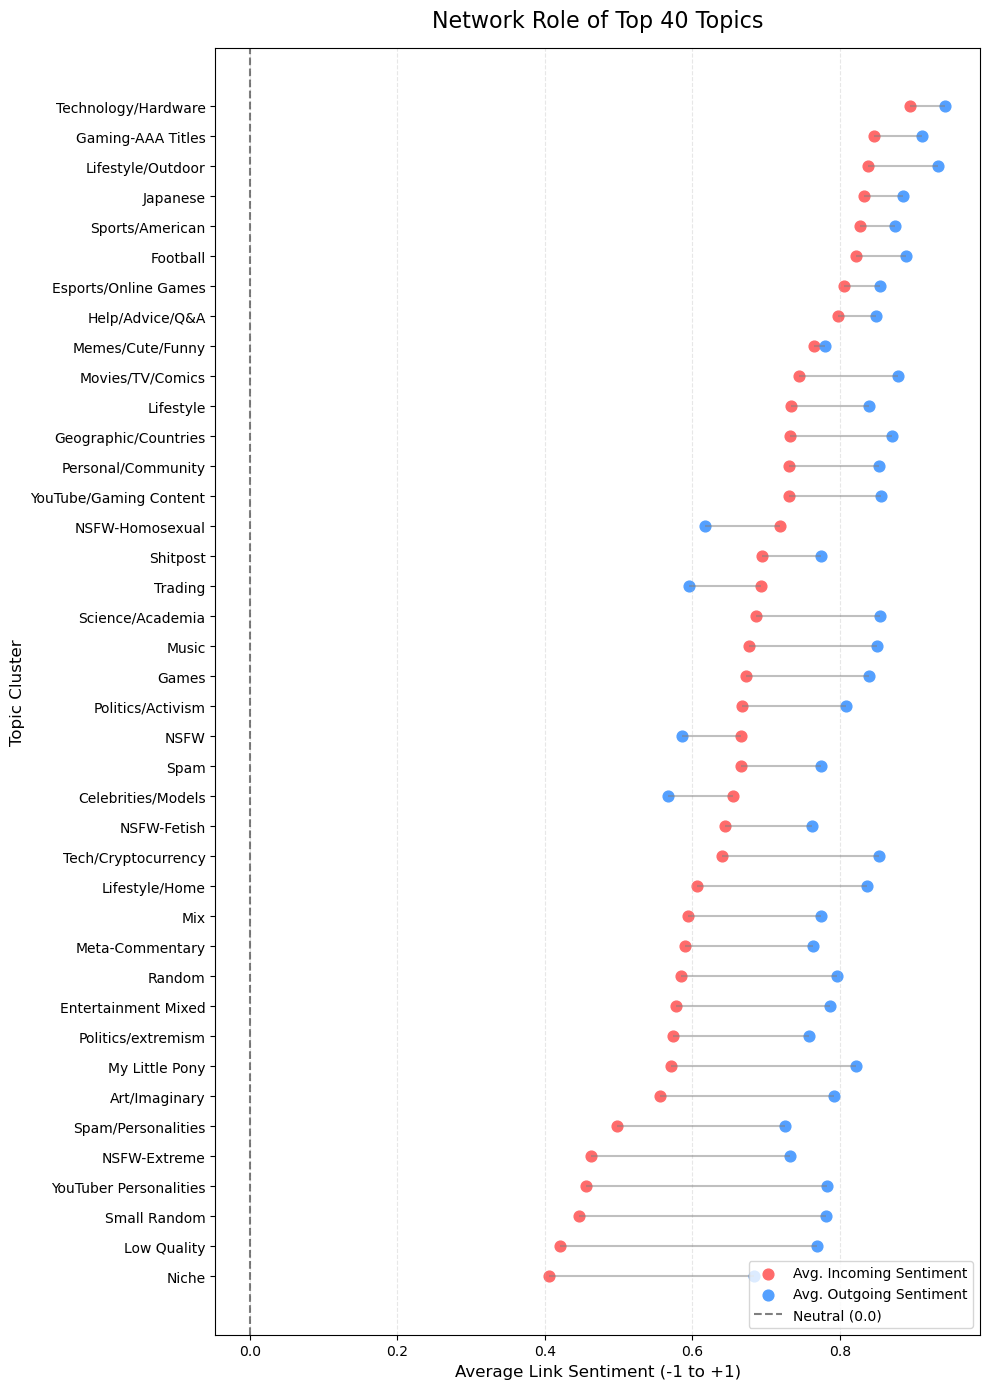

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step6_topic_network_role.png


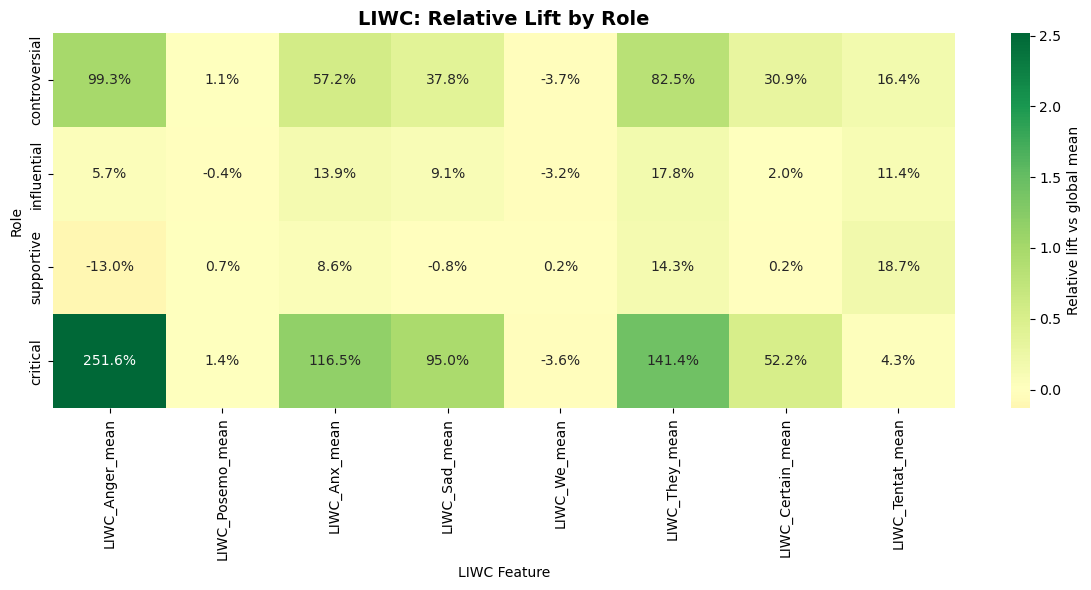

Generating step6_sem_struct_heatmap.png...


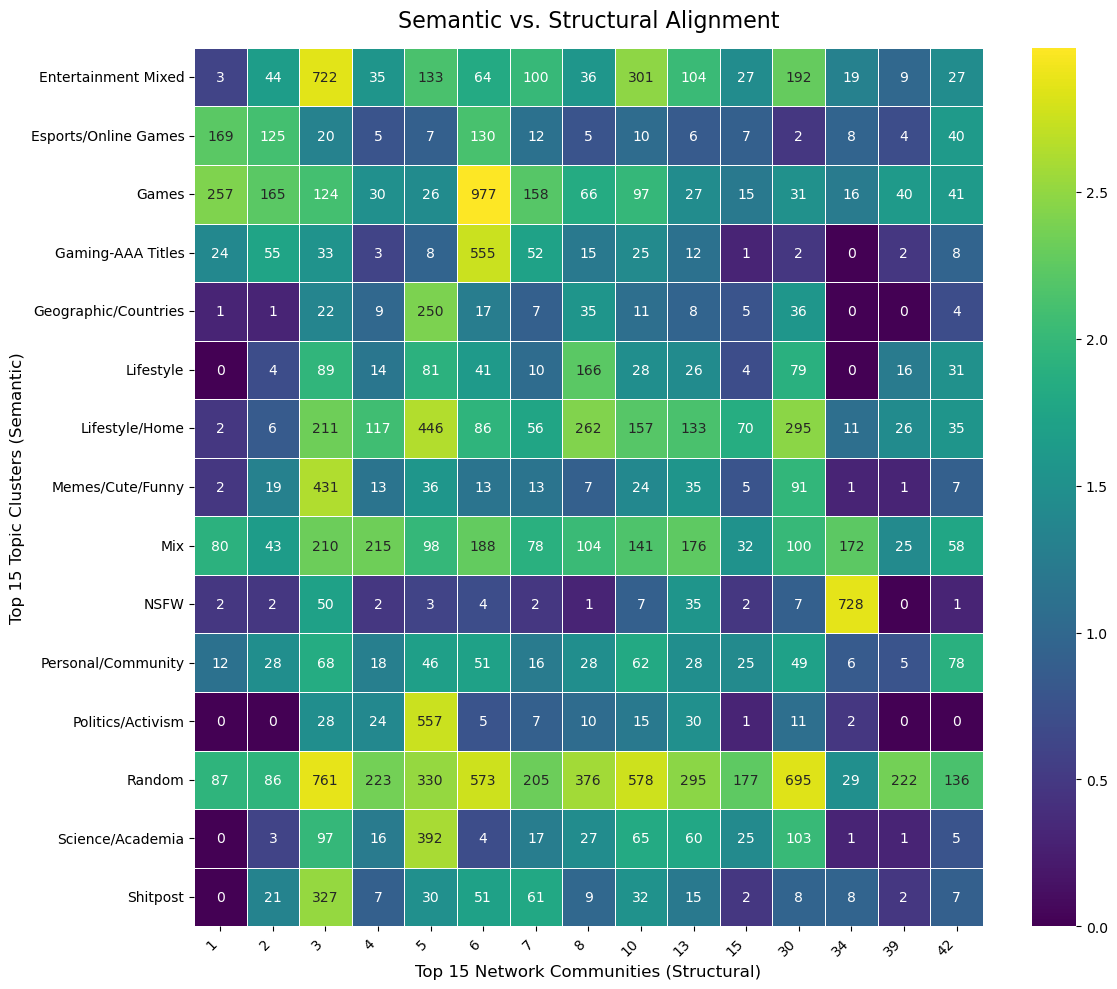

Saved PNG: /home/hamza/ada-2025-project-barrada/results/figures/step6_sem_struct_heatmap.png

STEP 6 FINAL VISUALIZATION COMPLETE
PNGs saved to: results/figures


In [30]:
print("--- Loading All Final Datasets ---")
df_final = load_final_dataset()
df_hyperlinks = load_hyperlinks_data()
df_clusters = load_topic_clusters()   
df_cluster_labels = load_cluster_labels()

# --- Generate Static PNGs ---
print("\n--- Generating 5 Static PNGs (will display below) ---")

if df_final is not None:
    plot_topic_network_role(df_final)
    plot_liwc_role_lift(df_final,role_columns=["role_controversial","role_influential","role_supportive", "role_critical"])
    plot_semantic_structural_heatmap(df_final)
else:
    print("Skipping PNG plots: 'final_dataset.csv' not found.")

print("\nSTEP 6 FINAL VISUALIZATION COMPLETE")
print(f"PNGs saved to: {FIGURES_DIR}")

### Step 7: Cluster Master Dataset Creation

**Goal:** Aggregate all subreddit-level features to the cluster level to create a comprehensive master dataset.
This step, handled by `ClusterAggregator`, consolidates all three data layers (Semantic, Psychological, Structural) at the cluster level.

This process will:
1. **Load** the `final_dataset.csv` (output from Step 6).
2. **Aggregate** network metrics (mean PageRank, max betweenness, etc.).
3. **Aggregate** all 65 LIWC psychological scores (mean anger, certainty, etc.).
4. **Calculate** cluster-to-cluster link patterns (insularity, sentiment flows).
5. **Extract** top-5 exemplar subreddits per cluster (by PageRank, betweenness, in-degree).
6. **Compute** derived metrics (toxicity score, analytical score, emotional score).
7. **Analyze** role distribution (percentage of cluster that is influential, critical, etc.).
8. **Save** the result to `cluster_master_dataset.csv`.

This gives us a **second master dataset**.

In [31]:
print("Initializing ClusterAggregator")
df_cluster_master = create_cluster_master_dataset(data_dir="data/processed")

print("Successfully generated and saved Cluster Master Dataset.")

print(f"\nCluster Master Dataset Shape: {df_cluster_master.shape}")
print(f"  Rows (clusters): {len(df_cluster_master)}")
print(f"  Columns (aggregated features): {len(df_cluster_master.columns)}")
print(f"  Total subreddits represented: {df_cluster_master['n_subreddits'].sum():,}")

print("\nColumn breakdown:")
print(f"  LIWC psychological scores: {len([c for c in df_cluster_master.columns if 'LIWC_' in c])}")
print(f"  Network metrics: {len([c for c in df_cluster_master.columns if any(x in c for x in ['pagerank', 'betweenness', 'degree', 'hub', 'authority'])])}")
print(f"  Link metrics: {len([c for c in df_cluster_master.columns if any(x in c for x in ['links', 'sentiment'])])}")
print(f"  Exemplar subreddits: {len([c for c in df_cluster_master.columns if 'top5' in c])}")
print(f"  Derived scores: {len([c for c in df_cluster_master.columns if 'score' in c])}")
print(f"  Role distribution: {len([c for c in df_cluster_master.columns if 'pct_role' in c])}")

print("\nSample of cluster master dataset (first 3 clusters):")
display_cols = ['cluster_id', 'cluster_label', 'n_subreddits', 'total_links',
                'toxicity_score', 'analytical_score', 'insularity']
display(df_cluster_master[display_cols].head(3))

Initializing ClusterAggregator
Loading datasets...
  Loaded final_dataset.csv: 67180 subreddits, 161 columns
  Loaded combined_hyperlinks.csv: 858488 links

Aggregating to cluster level...
  Processing: Art/Imaginary (n=195)
  Processing: Celebrities/Models (n=215)
  Processing: Entertainment Mixed (n=2156)
  Processing: Esports/Online Games (n=729)
  Processing: Football (n=298)
  Processing: Games (n=2755)
  Processing: Gaming-AAA Titles (n=949)
  Processing: Geographic/Countries (n=618)
  Processing: Help/Advice/Q&A (n=498)
  Processing: Japanese (n=159)
  Processing: Lifestyle (n=648)
  Processing: Lifestyle/Home (n=2349)
  Processing: Lifestyle/Outdoor (n=596)
  Processing: Low Quality (n=63)
  Processing: Memes/Cute/Funny (n=756)
  Processing: Meta-Commentary (n=426)
  Processing: Mix (n=2256)
  Processing: Movies/TV/Comics (n=476)
  Processing: Music (n=444)
  Processing: My Little Pony (n=102)
  Processing: NSFW (n=932)
  Processing: NSFW-Extreme (n=378)
  Processing: NSFW-Feti

,cluster_id,cluster_label,n_subreddits,total_links,toxicity_score,analytical_score,insularity
0,18,Art/Imaginary,195,1410,-0.010638,0.034632,0.201022
1,19,Celebrities/Models,215,1289,-0.014603,0.023748,0.081376
2,34,Entertainment Mixed,2156,27457,-0.017822,0.036033,0.012240


### Step 7 Results: Cluster-Level Pattern Discovery

Now that we have aggregated all features to the cluster level, we can identify high-level patterns across Reddit's 40 major topic communities. This dataset enables us to answer questions like:

* **Which topic clusters are most toxic?** (High anger + swear - positive emotion)
* **Which clusters are echo chambers?** (High insularity + high certainty)
* **Which clusters act as bridges?** (High betweenness, analytical language)
* **How do different topics compare in sentiment, psychology, and network position?**

In [32]:
print("CLUSTER-LEVEL INSIGHTS")

print("\n1. TOP 5 MOST TOXIC CLUSTERS")
print("   (Anger + Swear - Positive Emotion)\n")
toxic_clusters = df_cluster_master.nlargest(5, 'toxicity_score')[
    ['cluster_label', 'toxicity_score', 'n_subreddits', 'top5_by_pagerank']
]
display(toxic_clusters)

print("\n2. TOP 5 MOST ANALYTICAL CLUSTERS")
print("   (Insight + Certainty + Cognitive Processing)\n")
analytical_clusters = df_cluster_master.nlargest(5, 'analytical_score')[
    ['cluster_label', 'analytical_score', 'n_subreddits', 'top5_by_pagerank']
]
display(analytical_clusters)

print("\n3. TOP 5 MOST INSULAR CLUSTERS (Echo Chamber Candidates)")
print("   (Internal Links / Total Links)\n")
insular_clusters = df_cluster_master.nlargest(5, 'insularity')[
    ['cluster_label', 'insularity', 'n_subreddits', 'top5_by_pagerank']
]
display(insular_clusters)

print("\n4. TOP 5 CLUSTERS WITH HIGHEST SENTIMENT ASYMMETRY")
print("   (Receive Much More Negative Than They Send)\n")
asymmetric_clusters = df_cluster_master.nsmallest(5, 'sentiment_asymmetry')[
    ['cluster_label', 'sentiment_asymmetry', 'avg_in_sentiment', 'avg_out_sentiment', 'top5_by_pagerank']
]
display(asymmetric_clusters)

print("\n5. TOP 5 MOST CONNECTED CLUSTERS (Network Hubs)")
print("   (By Total Link Volume)\n")
connected_clusters = df_cluster_master.nlargest(5, 'total_links')[
    ['cluster_label', 'total_links', 'total_links_in', 'total_links_out', 'top5_by_pagerank']
]
display(connected_clusters)

print("\n6. AVERAGE ROLE DISTRIBUTION ACROSS ALL CLUSTERS")
print("   (Mean % of subreddits with each role)\n")
role_summary = df_cluster_master[[
    'pct_role_influential', 
    'pct_role_supportive', 
    'pct_role_critical', 
    'pct_role_controversial'
]].mean()
print(role_summary.to_string())


CLUSTER-LEVEL INSIGHTS

1. TOP 5 MOST TOXIC CLUSTERS
   (Anger + Swear - Positive Emotion)



,cluster_label,toxicity_score,n_subreddits,top5_by_pagerank
9,Japanese,-0.001320,159,"newsokur, newsokunomoral, highlevelkarma, lowl..."
13,Low Quality,-0.009484,63,"springfieldtbirds, mubookclub, clannews, mbzei..."
27,Politics/extremism,-0.010469,367,"politics, the_donald, mhoc, christianity, kota..."
0,Art/Imaginary,-0.010638,195,"imaginarynetwork, imaginarylandscapes, specula..."
23,NSFW-Homosexual,-0.010978,124,"awwnime, kreiswichs, totallystraight, wsgy, ke..."



2. TOP 5 MOST ANALYTICAL CLUSTERS
   (Insight + Certainty + Cognitive Processing)



,cluster_label,analytical_score,n_subreddits,top5_by_pagerank
8,Help/Advice/Q&A,0.051731,498,"askreddit, iama, explainlikeimfive, tifu, asks..."
36,Technology/Hardware,0.043967,386,"technology, android, buildapc, oculus, sysadmin"
27,Politics/extremism,0.042764,367,"politics, the_donald, mhoc, christianity, kota..."
10,Lifestyle,0.042032,648,"worldnews, news, travel, internetisbeautiful, ..."
6,Gaming-AAA Titles,0.041641,949,"pcmasterrace, games, minecraft, pokemongo, sma..."



3. TOP 5 MOST INSULAR CLUSTERS (Echo Chamber Candidates)
   (Internal Links / Total Links)



,cluster_label,insularity,n_subreddits,top5_by_pagerank
34,Sports/American,0.556728,361,"nfl, nba, hockey, cfb, baseball"
9,Japanese,0.481871,159,"newsokur, newsokunomoral, highlevelkarma, lowl..."
4,Football,0.396827,298,"soccer, mls, wec, naslsoccer, cricket"
36,Technology/Hardware,0.259115,386,"technology, android, buildapc, oculus, sysadmin"
18,Music,0.258497,444,"music, electronicmusic, hiphopheads, metalcore..."



4. TOP 5 CLUSTERS WITH HIGHEST SENTIMENT ASYMMETRY
   (Receive Much More Negative Than They Send)



,cluster_label,sentiment_asymmetry,avg_in_sentiment,avg_out_sentiment,top5_by_pagerank
10,Lifestyle,-0.236601,0.715851,0.952452,"worldnews, news, travel, internetisbeautiful, ..."
1,Celebrities/Models,-0.164990,0.786492,0.951482,"celebs, cosplaygirls, watchitfortheplot, gentl..."
38,YouTube/Gaming Content,-0.123058,0.799176,0.922235,"videos, gaming, art, fivenightsatfreddys, game..."
17,Movies/TV/Comics,-0.103152,0.840604,0.943757,"movies, anime, starwars, television, fantasy"
7,Geographic/Countries,-0.102694,0.777789,0.880483,"india, europe, canada, documentaries, programming"



5. TOP 5 MOST CONNECTED CLUSTERS (Network Hubs)
   (By Total Link Volume)



,cluster_label,total_links,total_links_in,total_links_out,top5_by_pagerank
15,Meta-Commentary,157439,21179,136260,"subredditdrama, bestof, undelete, subredditoft..."
8,Help/Advice/Q&A,145653,103604,42049,"askreddit, iama, explainlikeimfive, tifu, asks..."
30,Shitpost,127234,51422,75812,"showerthoughts, writingprompts, nosleep, outof..."
6,Gaming-AAA Titles,118336,70036,48300,"pcmasterrace, games, minecraft, pokemongo, sma..."
14,Memes/Cute/Funny,104270,87862,16408,"pics, funny, todayilearned, gifs, wtf"



6. AVERAGE ROLE DISTRIBUTION ACROSS ALL CLUSTERS
   (Mean % of subreddits with each role)

pct_role_influential      0.308710
pct_role_supportive       0.255646
pct_role_critical         0.016019
pct_role_controversial    0.018327


## Research Questions Analysis

**Statistical Methods:**
- Correlation analysis (Pearson r)
- T-tests for group comparisons
- Flow matrices for sentiment patterns

We conducted **statistical tests** organized into **5 thematic areas** to systematically explore Reddit's conflict dynamics, echo chambers, and power structures.

**Approach:**
- Each research question uses correlation analysis, t-tests, or network flow metrics
- Results are saved to `data/processed/rq_analysis/` (20 CSV files)
- The analysis below informed our data story, which presents a curated narrative of key findings

**Themes Covered:**
1. **Roles & Psychology** 
2. **Echo Chambers & Isolation**
3. **Network Structure** 
4. **Conflict Patterns**
5. **Power Dynamics** 

**Note:** Not all research questions appear in the final data story. The story prioritizes narrative coherence over exhaustive reporting. This notebook contains the complete technical analysis.

---

### Theme 1: Roles & Psychology

**Research Questions:**
- RQ1.1: Linguistic patterns by role (Critical, Supportive, Influential, Controversial)
- RQ1.2: Emotion dominance in link types (positive vs negative)
- RQ1.3: Emotional asymmetry (language used vs language received)
- RQ1.4: Ideological neighbors (within-cluster vs cross-cluster sentiment)

### Theme 2: Echo Chambers & Isolation

**Research Questions:**
- RQ2.1: Certainty and insularity correlation
- RQ2.2: Echo chamber detection (semantic-structural alignment)
- RQ2.2: Anatomy of isolation (predictors of insularity)

### Theme 3: Network Structure

**Research Questions:**
- RQ3.1: Betweenness predictors (what makes a bridge?)
- RQ3.2: Topic bridges (cross-cluster linking patterns)
- RQ3.3: Cluster rivalries & alliances (sentiment flow networks)

### Theme 4: Conflict Patterns

**Research Questions:**
- RQ4.1: Role distribution by cluster
- RQ4.2: External negativity
- RQ4.3: Internal civility
- RQ4.4: Vocabulary of peace (what predicts internal conflict?)
- RQ4.5: Vocabulary of war (what predicts external attacks?)

### Theme 5: Power Dynamics

**Research Questions:**
- RQ5.1: Punching bag index (net toxicity flow)
- RQ5.2: Power formula (PageRank predictors)
- RQ5.3: David vs Goliath (do attacks flow upward or downward?)
- RQ5.4: Toxicity contagion (hate breeds hate?)
- RQ5.5: Critics vs trolls (cognitive vs emotional negativity)


In [33]:
print("TESTS FOR RESEARCH QUESTIONS")

rq = ResearchQuestions(data_dir='data/processed')
    
rq.run_all() 


TESTS FOR RESEARCH QUESTIONS
RESEARCH QUESTIONS: STATISTICAL ANALYSIS PIPELINE

[DATA LOADING]
Loading datasets...
Loaded final_dataset.csv: 67,180 subreddits
Loaded combined_hyperlinks.csv: 858,488 links
Loaded cluster_master_dataset.csv: 40 clusters

Data loaded successfully.



THEME 1: ROLES & PSYCHOLOGY


RQ1: LINGUISTIC PATTERNS BY ROLE

Role Comparison (Mean LIWC Scores):
         role  n_subreddits  LIWC_Anger_mean  LIWC_Posemo_mean  LIWC_Negemo_mean  LIWC_Certain_mean
  Influential          8923         0.006662          0.026155          0.013472           0.006631
   Supportive          6635         0.005480          0.026432          0.011708           0.006515
     Critical           594         0.022156          0.026614          0.035603           0.009893
Controversial           454         0.012558          0.026547          0.022518           0.008511


RQ2: EMOTION DOMINANCE IN LINK TYPES

Analyzing 70 LIWC features across link sentiment...

Top 10 Features Dominatin


## Summary of Key Findings

Based on our analysis of 20 research questions, the headline discoveries are:

1. **Insurgency > Bullying** (RQ4.8): 73.9% of attacks punch UP (low-PageRank → high-PageRank)
2. **Isolation ≠ Toxicity** (RQ2.1): Japanese cluster is 91.8% isolated but 99.8% internally civil
3. **Swearing Dominates Conflict** (RQ1.2): 10.1× higher in negative vs positive links
4. **Bridges Speak Informally** (RQ3.1): Betweenness correlates with casual language, not authority

**For the complete narrative and interactive visualizations, see our [data story](https://epfl-ada.github.io/ada-2025-project-barrada).**

## Web Visualization Data Preparation

To power the interactive visualizations on our data story website, we generate 11 JSON files from our processed datasets.

**Purpose:** Export analysis results in web-friendly format for D3.js and Plotly visualizations.

**Outputs:**
- 11 JSON files saved to `docs/assets/data/`
- Includes: network nodes/edges, rivalry flows, toxicity sankey, echo chamber data, role distributions, power correlations, bridge predictors, and civility comparisons

In [34]:
prep = VisualizationDataPrep(
    data_dir="data/processed",
    output_dir="docs/assets/data"
)

prep.run_all()


COMPLETE VISUALIZATION DATA PREPARATION
Creating nodes.json...
Created docs/assets/data/nodes.json with 40 nodes

Creating edges.json...
Created docs/assets/data/edges.json with 283 edges

Creating rivalry.json...
Created docs/assets/data/rivalry.json

Creating insurgency.json...
Created docs/assets/data/insurgency.json

Creating toxicity.json...
Created docs/assets/data/toxicity.json

Creating echo.json...
Created docs/assets/data/echo.json with 40 clusters

Creating roles.json...
Created docs/assets/data/roles.json

Creating power.json...
Created docs/assets/data/power.json

Creating bridges.json...
Created docs/assets/data/bridges.json

Creating roles_scatter.json...
Created docs/assets/data/roles_scatter.json with 200 nodes

Creating civility.json...
Created docs/assets/data/civility.json
All JSON files created successfully!
Output directory: docs/assets/data


**Pipeline Complete.** All analysis outputs, visualizations, and web data files have been generated.